<a id='top'></a>
<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

# Master Background Subtraction for Multi-Object Spectroscopy (MOS) 

**Authors**: Kayli Glidic (kglidic@stsci.edu); NIRSpec Instrument Team <br>
**Created On**: June, 2024 ([JWebbinar 33](https://www.stsci.edu/jwst/science-execution/jwebbinars.html#h3-dc1c3cd6-f1aa-45c4-b73f-e93cc96ff4a7:~:text=33%20%2D%20JWST%20NIRSpec%20MOS%20Data%20Reduction))<br>
**Updated On**: September, 2025. <br>
**Pipeline Version**: 1.19.1 (Build 12.0, Context jwst_1413.pmap)

**Purpose**:<br>
The primary goal of this notebook is to demonstrate the master background subtraction method offered by the *James Webb Space Telescope* (JWST) Calibration Pipeline for Near-Infrared Spectrograph (NIRSpec) MOS data. 

**[Data](#data)**:<br>
This notebook is set up to use observations of the 1.2 Min Zodi Benchmark Field with the PRISM disperser obtained by Proposal ID (PID) 1448, Observation 11.

**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**:<br>
This notebook was last updated with the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST Calibration Reference Data System (CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).<br>

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.**
Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-mos-known-issues#NIRSpecFSKnownIssues-Resamplingof2-Dspectra&gsc.tab=0:~:text=MOS%20Known%20Issues-,NIRSpec%20MOS%20Known%20Issues,-Known%20issues%20specific) for this build related to master background subtraction are noted in the notebook. 

---

## Table of Contents
* [1. Introduction](#intro)
* [2. Import Library](#imports)
* [3. Directory Setup](#dir_setup)
* [4. Download the Data](#data)
* [5. Vetting the Background Spectra](#bkg_vetting)
    * [5.1 Stage 2: Spec2Pipeline -- No Background Subtraction Applied](#stage2)
    * [5.2 Check the Background Variation](#variation)
* [6. Source and Slitlet Information: MSA Metadata File](#metadata)
    * [6.1 Edit the MSA Metadata File for Master Background Subtraction](#metafile_mb)
* [7. Master Background Subtraction: Pipeline Generated Master Background Spectrum](#masterbkg)
    * [7.1 Identify Unmasked Hot/Bad Pixels](#hotbadpx)
* [8. Master Background Subtraction: User Supplied Master Background Spectrum](#manual)
    * [8.1 Re-extraction of 1-D Backgrounds Using Modified EXTRACT1D Reference File](#extraction)
* [9. Conclusion](#conclusion)

---
  
## 1. Introduction <a id='intro'></a>

JWST observations detect background emission from various sources: the zodiacal cloud, Milky Way Galaxy, thermal self-emission from the observatory itself, and stray light from out-of-field sky ([JDocs](https://jwst-docs.stsci.edu/jwst-general-support/jwst-background-model)). To remove this unwanted excess signal from the spectral traces of science targets, the Space Telescope Science Institute (STScI) [JWST Calibration Pipeline](https://jwst-pipeline.readthedocs.io/en/latest/) provides two standard background subtraction methods for NIRSpec MOS observations, one of which is called "master background" subtraction. 


Master background subtraction is a technique implemented by the *[`MasterBackgroundMosStep`](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.master_background.MasterBackgroundMosStep.html#jwst.master_background.MasterBackgroundMosStep)* in the *[`calwebb_spec2`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)* pipeline for MOS mode observations. This removal strategy relies on an independent, flux-calibrated 1-D master background spectrum, which can be provided directly by the user or generated on the fly with background data from predefined sky pixels ([Alves de Oliveira et al., 2018](https://arxiv.org/pdf/1805.06922)). For MOS observations, these come from designated background MSA slitlets ("blank sky" shutters assigned in the MSA configuration) within the same exposure as the science targets. The detailed list of operations performed when applying master background subtraction to MOS data during *[`calwebb_spec2`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)* processing is as follows:




1. Process all slitlets in the MOS exposure up through the [*`extract_2d`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/extract_2d/index.html) and [*`srctype`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/srctype/index.html) steps (includes: [*`assign_wcs`*](https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/main.html), [*`imprint`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/imprint/index.html), [*`msa_flagging`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/msaflagopen/index.html), and optionally [*`nsclean`*](https://jwst-pipeline.readthedocs.io/en/latest/jwst/nsclean/index.html#nsclean-step)).
2. The [*`MasterBackgroundMosStep`*](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.master_background.MasterBackgroundMosStep.html#jwst.master_background.MasterBackgroundMosStep) step temporarily applies remaining calibration steps up through [*`photom`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/photom/index.html) to all slits, treating them all as extended sources (appropriate for background signal), and saving the extended source correction arrays for each slit in an internal copy of the data model (includes: [*`flat_field`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/flatfield/index.html#flatfield-step), [*`barshadow`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/barshadow/index.html), [*`wavecorr`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/wavecorr/index.html), [*`pathloss`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pathloss/index.html)).
3. <a id='step3'></a> If a user-supplied master background spectrum is not given, the [*`resample_spec`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/index.html) and [*`extract_1d`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/extract_1d/index.html) steps are applied to the calibrated background slits, resulting in extracted 1-D background spectra.
4. The 1-D background spectra are combined, using the [*`combine_1d`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/combine_1d/index.html) step, into a master background spectrum.
5. If a user-supplied master background is given, steps 3 and 4 are skipped and the user-supplied spectrum is inserted into the processing flow.
6. The master background spectrum (either user-supplied or created on-the-fly) is expanded into the 2-D space of each slit.
7. The 2-D background “image” for each slit is processed in **inverse** mode through the [*`photom`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/photom/index.html), [*`barshadow`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/barshadow/index.html), [*`pathloss`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pathloss/index.html), and [*`flat_field`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/flatfield/index.html#flatfield-step) steps, using the correction arrays that were computed in step 2, so that the background data now matches the partially calibrated background signal in each slit.
8. The corrected 2-D background is subtracted from each open slitlet.
9. The background-subtracted slits are processed through all remaining *`calwebb_spec2`* calibration steps, using the corrections appropriate for the source type in each slit.

[More Info ...](https://jwst-pipeline.readthedocs.io/en/stable/jwst/master_background/description.html#nirspec-master-background-corrections:~:text=Fixed%2DSlit%20exposures.-,NIRSpec%20MOS%20Mode,-Master%20background%20subtraction)

---

## 2. Import Library <a id='imports'></a>


### Set CRDS Context and Server
Before importing `CRDS` and `JWST` modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline. If the local CRDS cache directory has not been set, it will automatically be created in the home directory.<br><br>
[Build Context Table](https://jwst-crds.stsci.edu/display_build_contexts/)

In [43]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# ------------------------Set CRDS context and paths------------------------

# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#os.environ['CRDS_CONTEXT'] = 'jwst_1413.pmap'  # CRDS context for 1.19.1

import os

# Set CRDS cache directory to user home if not already set.
if os.getenv('CRDS_PATH') is None:
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds_cache')

# Check whether the CRDS server URL has been set. If not, set it.
if os.getenv('CRDS_SERVER_URL') is None:
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Output the current CRDS path and server URL in use.
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /Users/kglidic/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


<div class="alert alert-block alert-info">

Installation instructions for the JWST pipeline found here: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io) •
[Github](https://github.com/spacetelescope/jwst)

</div>

In [45]:
# ------ General Imports ------
import glob
import json
import time as tt
import warnings
import logging
import matplotlib.pyplot as plt
from astropy.io import fits
from astroquery.mast import Observations

# ------ JWST Imports ------
import crds
import jwst
from stpipe import crds_client
from crds.client import api
from jwst.pipeline import Spec2Pipeline
from jwst.extract_1d import Extract1dStep

# ------ Convenience Function Imports ------
from master_background_plot_tools import plot_spectra, metafile_editor
from master_background_plot_tools import manually_define_dq_flags, mean_background_variations

# Hide all log and warning messages.
logging.disable(logging.ERROR)
warnings.simplefilter("ignore", RuntimeWarning)

# Set the default font size for all plots.
plt.rcParams.update({'font.size': 12})

# Print the JWST pipeline version and the default CRDS context for that version.
default_context = crds.get_default_context('jwst', state='build')
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print(f"Default CRDS Context for JWST Version {jwst.__version__}: {default_context}")
print(f"Using CRDS Context: {os.environ.get('CRDS_CONTEXT', default_context)}")

JWST Calibration Pipeline Version = 1.20.0
Default CRDS Context for JWST Version 1.20.0: jwst_1462.pmap
Using CRDS Context: jwst_1462.pmap


---

## 3. Directory Setup <a id='dir_setup'></a>


In [46]:
# To rerun the notebook set runflag=True.
runflag = True

# Define a parent output directory.
output_dir = './masterbkg_subtraction_MOS_demo/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

---

## 4. Download the Data <a id='data'></a>

This notebook is using commissioning data from JWST proposal [1448](https://www.stsci.edu/jwst/science-execution/program-information?id=1448) Observation 11, which looked at the background in the 1.2 Min Zodi Benchmark Field, where the zodical background is 1.2 times higher than the celestial minimum. All open slitlets in this dataset's MSA configuration observed background. 

<div class="alert alert-block alert-info"> 
    
<b>Tip:</b> The data in this notebook is public and does not require a MAST token. To download other non-public datasets from MAST, you must input your MAST authorization token. Get your MAST Token Here: https://auth.mast.stsci.edu/token. To utilize ASTROQUERY for downloading, please follow the [documented installation procedures](https://astroquery.readthedocs.io/en/latest/).


    
</div> 

| Target: 1.2 Min Zodi Benchmark Field | | |
|:-----------:|:-------:|---|
| Proposal ID | [1448](https://www.stsci.edu/jwst/science-execution/program-information?id=1448) |
| [GRATING/FILTER](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-dispersers-and-filters)   | PRISM/CLEAR | λ: 0.6–5.3 μm (a low resolution, R ~ 100) |
|   DURATION  | 3545.1 [s] | Total duration of one exposure |
|   READPATT  | NRSIRS2RAPID | Readout Pattern |
|   NOD_TYPE  | 3-SHUTTER-SLITLET | Nod pattern type |
|   NUMDTHPT  | 3 | Total number of points in pattern |
|   SRCTYAPT  | UNKNOWN | Source Type selected in APT |

> **Note:** For MOS observations, there are gaps in spectral coverage caused by the physical distance between the two detectors, referred to as detector wavelength gaps. The range of wavelengths lost in the gap is different for different shutters in the MSA since the spectra from different shutters map to different locations on the detectors. Unlike fixed slits (FS) and integral field unit (IFU) observations, which suffer wavelength gap losses only in the R ~ 2,700 high spectral resolution mode, all grating and filter combinations for MOS observations have shutters that lose wavelengths to the gap. [More](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-multi-object-spectroscopy#NIRSpecMultiObjectSpectroscopy-Detectorwavelengthgaps) [Info ...](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-dispersers-and-filters)

In this notebook, we focus on one of the nodded exposures in this dataset. The cell below downloads one pre-processed countrate (*`_rate.fits`*) file and the corresponding MSA metadata file (*`_msa.fits`*) available in MAST. MAST products will be saved to a folder named `mast_products` within the designated output parent directory defined earlier in this notebook.

In [47]:
# Create a directory for the downloaded data from MAST.
mast_products_dir = output_dir+'mast_products/'
if not os.path.exists(mast_products_dir):
    os.makedirs(mast_products_dir)

In [48]:
# Download data from MAST.

# Setup your account.

# NOTE:
# The data in this notebook is public and does not require a token.
# For other data sets, uncomment the following line and enter your
# token at the prompt.

# Observations.login(token=None)
sessioninfo = Observations.session_info()

# Define the general search criteria.
obs = Observations.query_criteria(
        obs_collection='JWST',
        instrument_name=['NIRSPEC/MSA'],
        proposal_id='1448',
        obs_id='jw01448-o011_v000000001_nirspec_clear-prism')  # Observation 11.

# Print the list of products returned from the general serach criteria.
products = Observations.get_product_list(obs)

# Filter the list of products returned from the general search criteria.
filtered = Observations.filter_products(products,
                                        productSubGroupDescription=["RATE", "MSA"],
                                        mrp_only=False)

# Second filter: Grab one of the nod exposures for NRS2 and the MSA metadata file.
secondary_filtered = [entry for entry in filtered
                      if '_00001_nrs2' in entry['obs_id'] or 'msa' in entry['obs_id']]

# Print the secondary filtered products.
for k in secondary_filtered:
    print(k['productFilename'])

# Download the filtered products.
# This creates a mastDownload directory,
# unless you set flat=True and set a download_dir.
for i in range(len(secondary_filtered)):
    Observations.download_products(secondary_filtered[i], mrp_only=False, cache=True,
                                   flat=True, download_dir=mast_products_dir)

eppn: 
ezid: anonymous
anon: True
scopes: []
session: None
token: None
jw01448011001_01_msa.fits
jw01448011001_02101_00001_nrs2_rate.fits


In [49]:
# Download the most up-to-date barshadow correction reference file.
# This data was taken before the USEAFTER date set
# on the new barshadow reference file so we must manually override it.
refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_barshadow_0006.fits'])
barshadow_reffile = refs['jwst_nirspec_barshadow_0006.fits']

print(f"The barshadow reference file was saved to : {barshadow_reffile}")

The barshadow reference file was saved to : /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0006.fits


---

## 5. Vetting the Background Spectra <a id='bkg_vetting'></a>

Should contaminated backgrounds, like those affected by stray light or unmasked hot/bad pixels, be utilized in generating the master background, they will impact both the quality of the master background and the resulting background-subtracted spectra. Notably, unmasked hot pixels introduce positive spikes in the master background spectrum, which then translate to negative spikes in the final background-subtracted spectra. These pixels should be addressed before creating a master background. 

**To achieve the best results with master background subtraction, we recommend that users first check/vet their input background spectra before any additional processing.** In the following cells, we calibrate (without applying background subtraction steps), extract, and analyze each background spectrum. We identify uncontaminated background spectra to create a master background. Later in the notebook ([Section 7.1](#hotbadpx)), we demonstrate a manual method for identifying unflagged hot/bad pixels and updating their corresponding DQ flags.

In [50]:
# Create a directory for the calibrated products with no background subtraction applied.
output_dir_NObkg = output_dir+'nirspec_product_files_NObkg/'
if not os.path.exists(output_dir_NObkg):
    os.makedirs(output_dir_NObkg)

---

### 5.1 Stage 2: Spec2Pipeline -- No Background Subtraction Applied <a id='stage2'></a>

Initially, we process each background spectrum using the default settings and parameters employed by the *[MasterBackgroundMosStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.master_background.MasterBackgroundMosStep.html#jwst.master_background.MasterBackgroundMosStep)* within *[calwebb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)*. This provides users with an insight into the appearance of the background spectra that are extracted behind the scenes in the *[MasterBackgroundMosStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.master_background.MasterBackgroundMosStep.html#jwst.master_background.MasterBackgroundMosStep)*.

<div class="alert alert-block alert-info"> 

<b>Note:</b> Prior to Build 11.2 there was a known bug in the *`MasterBackgroundMosStep`* that prevented users from overriding parameters or reference files for the [*`resample_spec`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/index.html) and [*`extract_1d`*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/extract_1d/index.html) steps called during the extraction of background slits ([Step 3](#step3) in the processing). This bug has been fixed in Build 11.2. However, users working with an older version of the pipeline who wish to modify the default settings for these steps should create and provide a 1-D master background spectrum to the pipeline (demonstrated partially in [Section 7](#manual)).
</div>

In [51]:
# Stage 2 Processing -- No Background Subtraction Applied.
# Estimated runtime: ~13 minutes.
start = tt.time()

if runflag:

    # Process each rate file seperately.
    for rate_file in sorted(glob.glob(mast_products_dir+'*rate.fits')):

        # Ensure each rate file is pointing to the original MSA metadata file.
        with fits.open(rate_file, 'update') as ratefile_hdu:
            ratefile_hdu[0].header['MSAMETFL'] = (
                mast_products_dir + 'jw01448011001_01_msa.fits')
        ratefile_hdu.close()

        print("Applying Stage 2 Calibrations & Corrections to: " +
              os.path.basename(rate_file))

        # Adjust `slit_y_low`/`slit_y_high` as needed to center slitlet in 2-D cutout.
        spec2_params = {'assign_wcs': {'slit_y_low': -0.55, 'slit_y_high': 0.35},
                        'master_background_mos': {'skip': True}, # Skip master backgrond.
                        'bkg_subtract': {'skip': True},  # Skip pixel-to-pixel backgrond.
                        # Override for newest barshadow reference file - optional.
                        'barshadow': {'override_barshadow': barshadow_reffile}}

        Spec2Pipeline.call(rate_file, save_results=True,
                           output_dir=output_dir_NObkg, steps=spec2_params)

    print("Hurray! Stage 2 Processing Complete.")

end = tt.time()
print("Run time: ", round(end - start, 1) / 60.0, " min")

Applying Stage 2 Calibrations & Corrections to: jw01448011001_02101_00001_nrs2_rate.fits
Hurray! Stage 2 Processing Complete.
Run time:  3.978333333333333  min


---

### 5.2 Check the Background Variation <a id='variation'></a>

The following cell generates a plot showing individual background spectra overlaid with a sigma-clipped mean. 

Before computing the mean, the code filters out contaminated backgrounds based on their deviation from the median background spectrum, using a specified threshold. You can adjust this threshold and the sigma parameter for clipping to reduce the influence of outliers such as hot pixels and eliminate contaminated spectra. The plot also includes the coefficient of variation calculated between the background spectra and the sigma-clipped mean.

Additionally, if `save_mb` is set to True, the code generates and returns an X1D FITS file containing the calculated mean background spectrum. This file can later be used to provide the pipeline with a user-supplied 1D master background, as described in [Section 7](#manual). Also note that this is just one example of how to create your own master background — it's not the only method.


**NOTE**: By default, all background slits identified in the MSA metadata `SHUTTER_INFO` table are plotted. Alternatively, if a specific list of background slits is provided, only those slits are plotted. 

/Users/kglidic/Documents/pipeline/jdat_notebooks/notebooks/NIRSpec/mos_master_background/master_background_plot_tools.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metadata_tables[hdu_name] = table_data.to_pandas().applymap(lambda x: x.decode() if isinstance(x, bytes) else x)


Mean COV: 0.05880357497294263
Uncertainty of the Mean COV: 0.0006385244558403319


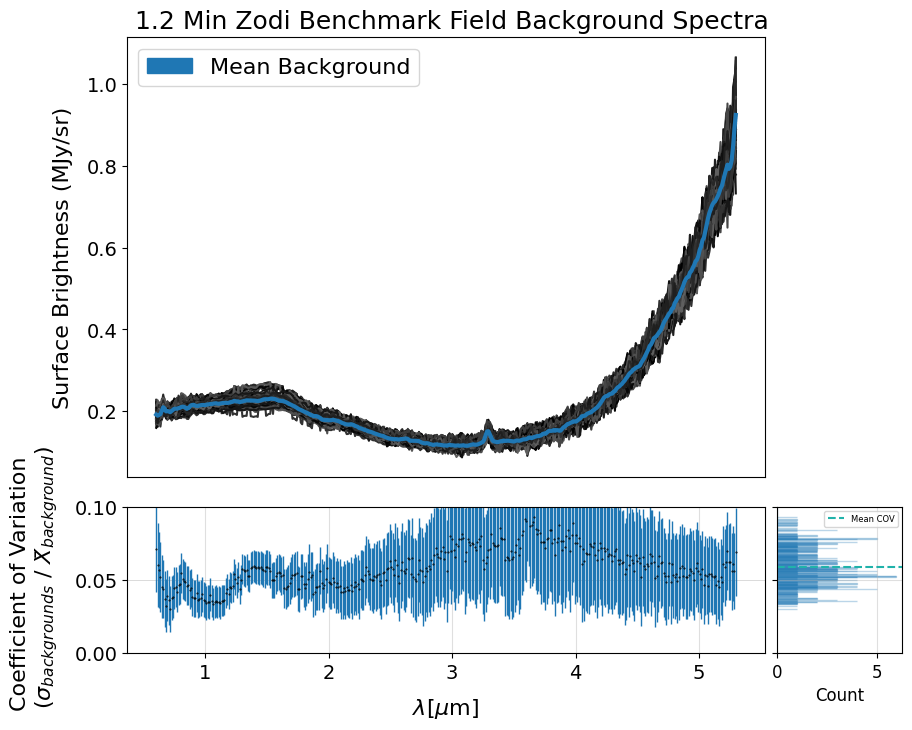

In [52]:
x1d_files = sorted(glob.glob(output_dir_NObkg+'*nrs2_x1d.fits'))
all_slits = list(map(str, list(range(2, 237))))  # All slit names for this dataset.

# Original MSA metadata file path.
metafile_og = mast_products_dir + 'jw01448011001_01_msa.fits'

good_bkg_slits = mean_background_variations(x1d_files, metafile_og,
                                            bin_wavelengths=False,
                                            vetted_backgrounds=all_slits,
                                            mad_threshold=5, sigma=3,
                                            mean_color='tab:blue',
                                            y_lim=None, save_mb=False)


The subset of background slits chosen below have been pre-selected for this demo to save time in processing. We intentionally include some spectra with hot pixels to illustrate their impact when incorporated into the creation of the 1D master background spectrum in the pipeline.

In [53]:
print(sorted(good_bkg_slits, key=int))

# Choose which background slits to use for the rest of the demo.
demo_background_slits = ['2', '9', '14', '38', '43']

['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117']


Slit 2: Y-START = 7.0 ; Y-STOP = 12.0
Slit 9: Y-START = 7.0 ; Y-STOP = 12.0
Slit 14: Y-START = 7.0 ; Y-STOP = 12.0
Slit 38: Y-START = 7.0 ; Y-STOP = 12.0
Slit 43: Y-START = 7.0 ; Y-STOP = 12.0


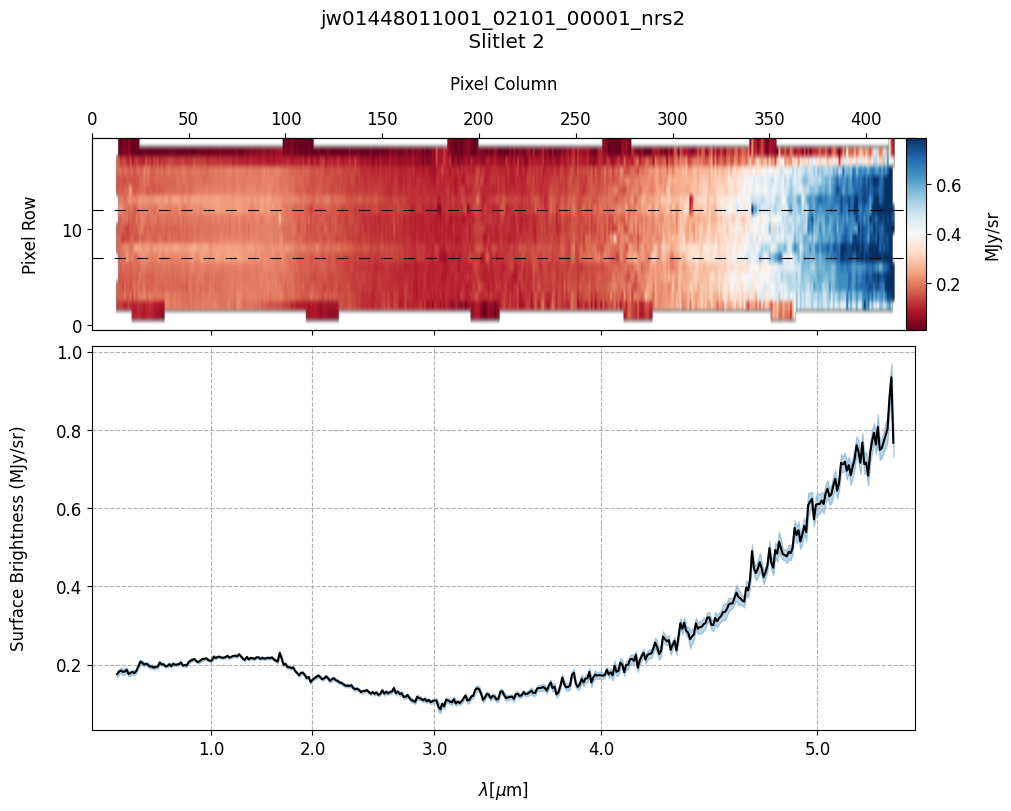

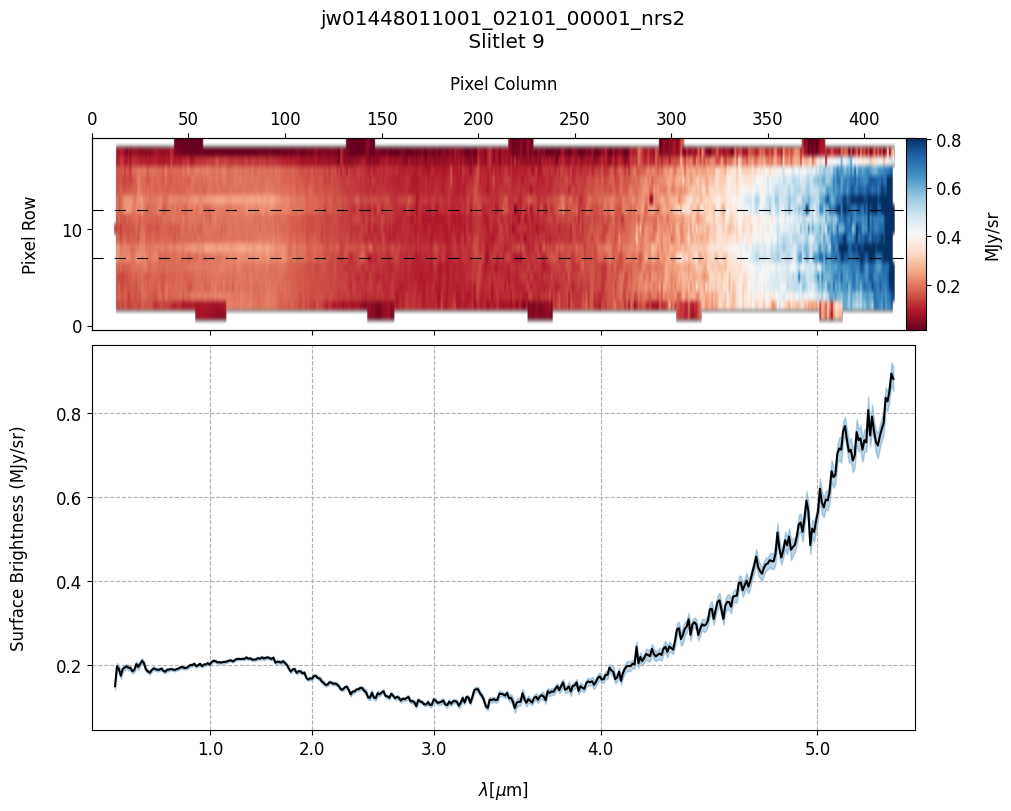

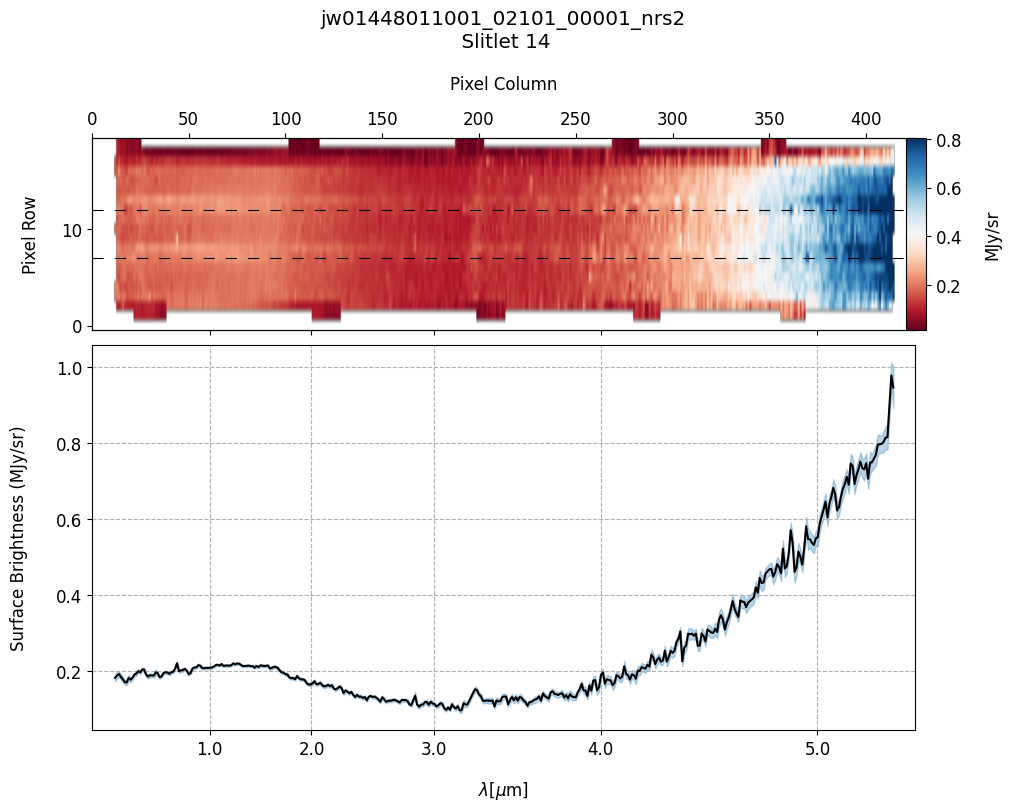

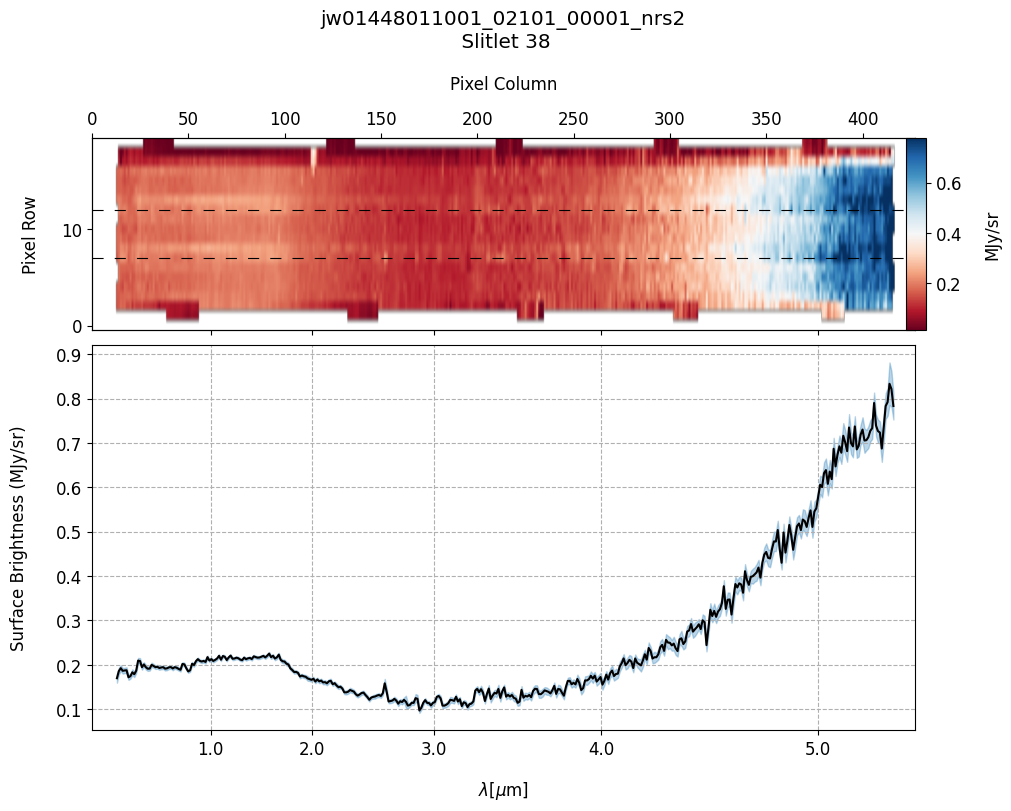

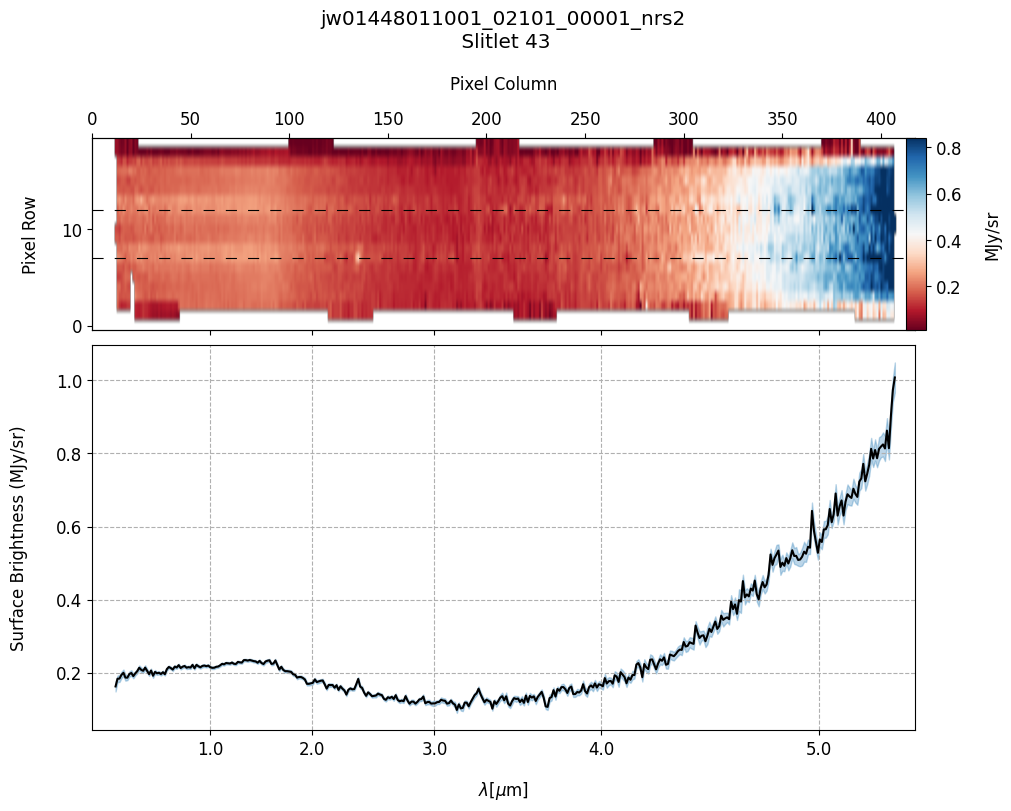

In [54]:
# Plot the master background subtracted spectra.
s2d_nobkg_files = sorted(glob.glob(output_dir_NObkg+'*nrs2_s2d.fits'))
x1d_nobkg_files = sorted(glob.glob(output_dir_NObkg+'*nrs2_x1d.fits'))

plot_spectra(s2d_nobkg_files, x1d_nobkg_files, slit_names=demo_background_slits,
             scale=1, cmap='RdBu', figsize=(10, 8), fill_nan=False, hist=False,
             ycolor='black', ecolor='tab:blue', plot_errors=True)

---

## 6. Source and Slitlet Information: MSA Metadata File <a id='metadata'></a>

The MSA metadata file is an essential processing component for MOS data in *[`calwebb_spec2`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)* processing. The MSA metadata file is a FITS file generated by the [MSA Planning Tool](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-apt-templates/nirspec-multi-object-spectroscopy-apt-template/nirspec-msa-planning-tool-mpt). The file contains the MSA shutter configuration image (`SHUTTER_IMAGE`) and two binary tables: `SHUTTER_INFO` and `SOURCE_INFO`.  The `SHUTTER_INFO` table specifies all the slitlets having one or more open shutters based on the MSA configuration for that observation. The `SOURCE_INFO` table contains information on each source in the plan. For a detailed walkthrough on MSA metadata files, see the [JDAT GitHub repository](https://github.com/spacetelescope/jdat_notebooks/tree/main).


<div class="alert alert-block alert-info">

<b>Note:</b> In countrate FITS files (*_rate.fits*), the primary header keyword (`MSAMETFL`) specifies the name of the MSA metadata file. The pipeline will reference this keyword to determine what file to use during processing. The pipeline will also expect the file to be in the same directory as the countrate products.
</div> 

---
### 6.1 Edit the MSA Metadata File for Master Background Subtraction <a id='metafile_mb'></a>

In the [Import Library](#imports), we introduce the `metafile_editor` function, tailored for this example dataset, which generates a modified MSA metadata file for master background subtraction. The modified MSA metadata file should exclusively contain slitlets with vetted backgrounds and science sources. In the `SHUTTER_INFO` table, background slitlets will have the background column marked as yes ('Y'), while slitlets with science sources will have the primary_source column marked as yes ('Y'). Additionally, each science source must be assigned a stellarity value in the `SOURCE_INFO` table. Any source with a stellarity value > 0.75 is classified as a point source, while a value between 0 and 0.75 gets classified as an extended source by the pipeline. If any source passed to `metafile_editor` is designated as a point source, its stellarity value will be set to 1.0.

To create a new MSA metadata file using `metafile_editor`, users must provide the following: 

* A list of tuples with the names of slitlets containing sources along with their corresponding source types, for example: (236, 'extended').
* A list of MSA slitlet names containing the vetted backgrounds.
* A path to the directory containing the original MSA metadata file downloaded from MAST.

Provided all the above-required parameters, the function will return the path to the newly created MSA metadata file. Users also have the option to display the new `SHUTTER_INFO` and `SOURCE_INFO` MSA metadata file tables by setting `show_tables=True`. The modified MSA metadata file for master background subtraction will have a suffix of *`_mb.fits`*. 

In [55]:
# Set the source and background slitlets.
# Can treat the source as a point source if desired.
source_slitlets = [('38', 'extended')]
demo_background_slits_meta = ['2', '9', '14', '43']

# Generate the master background subtraction MSA metadata data file.
metafile_mb = metafile_editor(source_slitlets, metafile_og,
                              bkg_slitlets=demo_background_slits_meta,
                              show_tables=True)

/Users/kglidic/Documents/pipeline/jdat_notebooks/notebooks/NIRSpec/mos_master_background/master_background_plot_tools.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metadata_tables[hdu_name] = table_data.to_pandas().applymap(lambda x: x.decode() if isinstance(x, bytes) else x)


---

## 7. Master Background Subtraction: Pipeline Generated Master Background Spectrum <a id='masterbkg'></a>

Process the MOS data using the modified MSA metadata file. The MSA metadata file will instruct the pipeline on which slits to extract a 1-D background spectrum from. 

<div class="alert alert-block alert-info">

<b>Note:</b> Prior to pipeline build 11.2, the *`MasterBackgroundMosStep`* would combine all extracted 1-D background spectra using a weighted average via the [*`combine_1d`*](https://jwst-pipeline.readthedocs.io/en/latest/jwst/combine_1d/description.html) step. However, this method often produced a contaminated master background spectrum, as it did not effectively filter out outlier pixels or spectra affected by source contamination and would require users to supply the 1-D master background. Beginning with build 11.2, the pipeline introduced two important parameters — [*`median_kernel`* and *`sigma_clip`*](https://jwst-pipeline.readthedocs.io/en/latest/jwst/master_background/arguments.html) — to the *`master_background_mos`* step to improve the quality of the resulting 1-D master background spectrum. For the purpose of this demonstration, however, we deliberately disable these parameters to illustrate the impact of using unfiltered background spectra.

</div> 


In [116]:
# Output directory for the master background.
output_dir_masterbkg = output_dir+'nirspec_product_files_masterbkg/'
if not os.path.exists(output_dir_masterbkg):
    os.makedirs(output_dir_masterbkg)

In [117]:
# Stage 2 Processing -- Master Background Subtraction Applied.
# Pipeline generated 1-D master background spectrum.
# Estimated runtime: ~13 minutes.
start = tt.time()

if runflag:

    # Process each rate file seperately.
    for rate_file in sorted(glob.glob(mast_products_dir+'*rate.fits')):
        
        # Update the MSA metadata file for master background subtraction.
        print("Changing MSAMETFL Keyword for {}".format(os.path.basename(rate_file)))
        with fits.open(rate_file, 'update') as ratefile_hdu:
            ratefile_hdu[0].header['MSAMETFL'] = os.path.basename(metafile_mb)
        ratefile_hdu.close()

        print("Applying Stage 2 Calibrations & Corrections to: " +
              os.path.basename(rate_file))

        # Adjust `slit_y_low`/`slit_y_high` as needed to center slitlet in 2-D cutout.
        spec2_params = {'assign_wcs': {'slit_y_low': -0.55, 'slit_y_high': 0.35},
                        # Save generated master background.
                        'master_background_mos': {'skip': False,
                                                  'save_background': True,
                                                  # New important parameters to improve master background.
                                                  # We turn them off for this demo to show the impact of
                                                  # using unfiltered background spectra.
                                                  'median_kernel': 1,
                                                  'sigma_clip': None,
                                                  'steps': {'barshadow':
                                                            {'override_barshadow': barshadow_reffile},
                                                            'flat_field': {'save_interpolated_flat':True}}},
                        'bkg_subtract': {'skip': True}, # Skip pixel-to-pixel.

                        # Fill non-science pixels with NaNs in the final
                        # background-subtracted resampled spectra (not 0's)
                        # so they don't get included in Extract1D step.
                        # Use resample weight type ivm as it lets through less outliers.
                        'resample_spec': {'fillval': 'nan', 'weight_type': 'ivm'},
                        # Override to use the newest barshadow file.
                        'barshadow': {'override_barshadow': barshadow_reffile}}

        Spec2Pipeline.call(rate_file, save_results=True,
                           output_dir=output_dir_masterbkg, steps=spec2_params)

        print("Hurray! Stage 2 Processing Complete.")

end = tt.time()
print("Run time: ", round(end - start, 1) / 60.0, " min")

Changing MSAMETFL Keyword for jw01448011001_02101_00001_nrs2_rate.fits
Applying Stage 2 Calibrations & Corrections to: jw01448011001_02101_00001_nrs2_rate.fits
Hurray! Stage 2 Processing Complete.
Run time:  0.4533333333333333  min


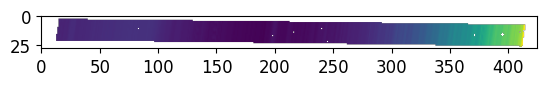

In [ ]:
sorted(glob.glob(output_dir_masterbkg+'*.fits'))
bkg = fits.open( './masterbkg_subtraction_MOS_demo/nirspec_product_files_masterbkg/jw01448011001_02101_00001_nrs2_masterbg2d.fits')[1].data
PATHLOSS_UN = fits.open( './masterbkg_subtraction_MOS_demo/nirspec_product_files_masterbkg/jw01448011001_02101_00001_nrs2_masterbg2d.fits')[10].data
BARSHADOW = fits.open( './masterbkg_subtraction_MOS_demo/nirspec_product_files_masterbkg/jw01448011001_02101_00001_nrs2_masterbg2d.fits')[5].data
FLAT = fits.open('./masterbkg_subtraction_MOS_demo/nirspec_product_files_masterbkg/jw01448011001_02101_00001_nrs2_interpolatedflat.fits')[1].data



plt.
plt.imshow(bkg/BARSHADOW/PATHLOSS_UN/FLAT)
plt.inshow 

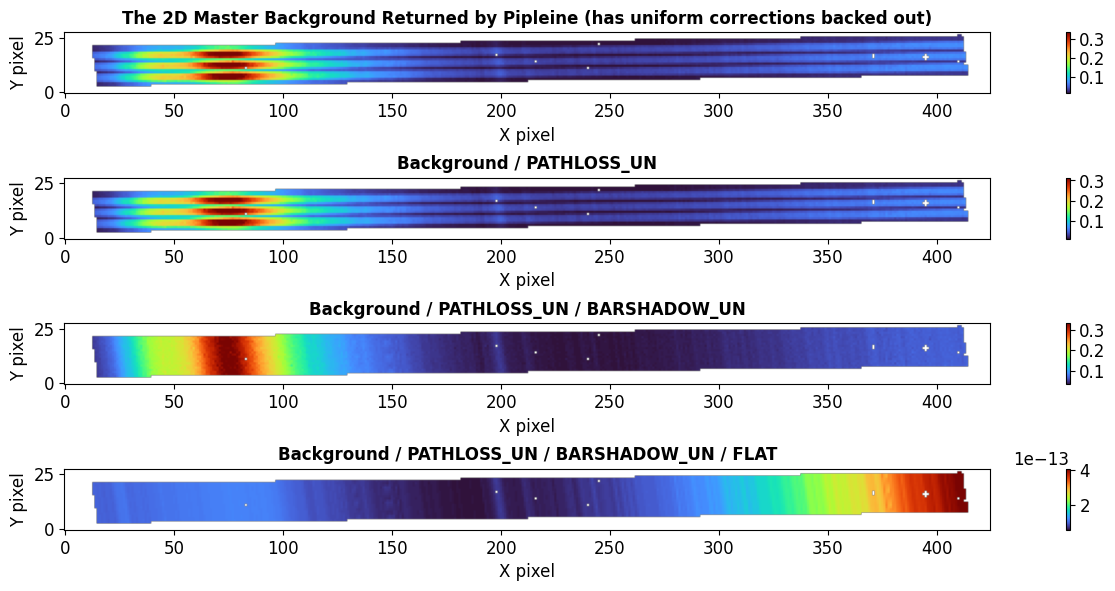

In [142]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import glob

# Load files (optional if you already know the paths)
# files = sorted(glob.glob(output_dir_masterbkg + '*.fits'))

# Read in data arrays
bkg = fits.open('./masterbkg_subtraction_MOS_demo/nirspec_product_files_masterbkg/jw01448011001_02101_00001_nrs2_masterbg2d.fits')[1].data
PATHLOSS_UN = fits.open('./masterbkg_subtraction_MOS_demo/nirspec_product_files_masterbkg/jw01448011001_02101_00001_nrs2_masterbg2d.fits')[10].data
BARSHADOW = fits.open('./masterbkg_subtraction_MOS_demo/nirspec_product_files_masterbkg/jw01448011001_02101_00001_nrs2_masterbg2d.fits')[5].data
FLAT = fits.open('./masterbkg_subtraction_MOS_demo/nirspec_product_files_masterbkg/jw01448011001_02101_00001_nrs2_interpolatedflat.fits')[1].data

# Avoid divide-by-zero and NaNs
eps = 1e-8
PATHLOSS_UN = np.where(PATHLOSS_UN == 0, eps, PATHLOSS_UN)
BARSHADOW = np.where(BARSHADOW == 0, eps, BARSHADOW)
FLAT = np.where(FLAT == 0, eps, FLAT)

# Prepare the list of steps
steps = [
    ('The 2D Master Background Returned by Pipleine (has uniform corrections backed out)', bkg),
    ('Background / PATHLOSS_UN', bkg / PATHLOSS_UN),
    ('Background / PATHLOSS_UN / BARSHADOW_UN', bkg / (PATHLOSS_UN * BARSHADOW)),
    ('Background / PATHLOSS_UN / BARSHADOW_UN / FLAT', bkg / (PATHLOSS_UN * BARSHADOW * FLAT))
]

# Plot
fig, axes = plt.subplots(4, 1, figsize=(20, 6))

for ax, (title, data) in zip(axes, steps):
    im = ax.imshow(data, origin='lower', cmap='turbo', 
                   vmin=np.nanpercentile(data, 1), vmax=np.nanpercentile(data, 99))
    ax.set_title(title, fontsize=12, weight='bold')
    ax.set_xlabel('X pixel')
    ax.set_ylabel('Y pixel')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


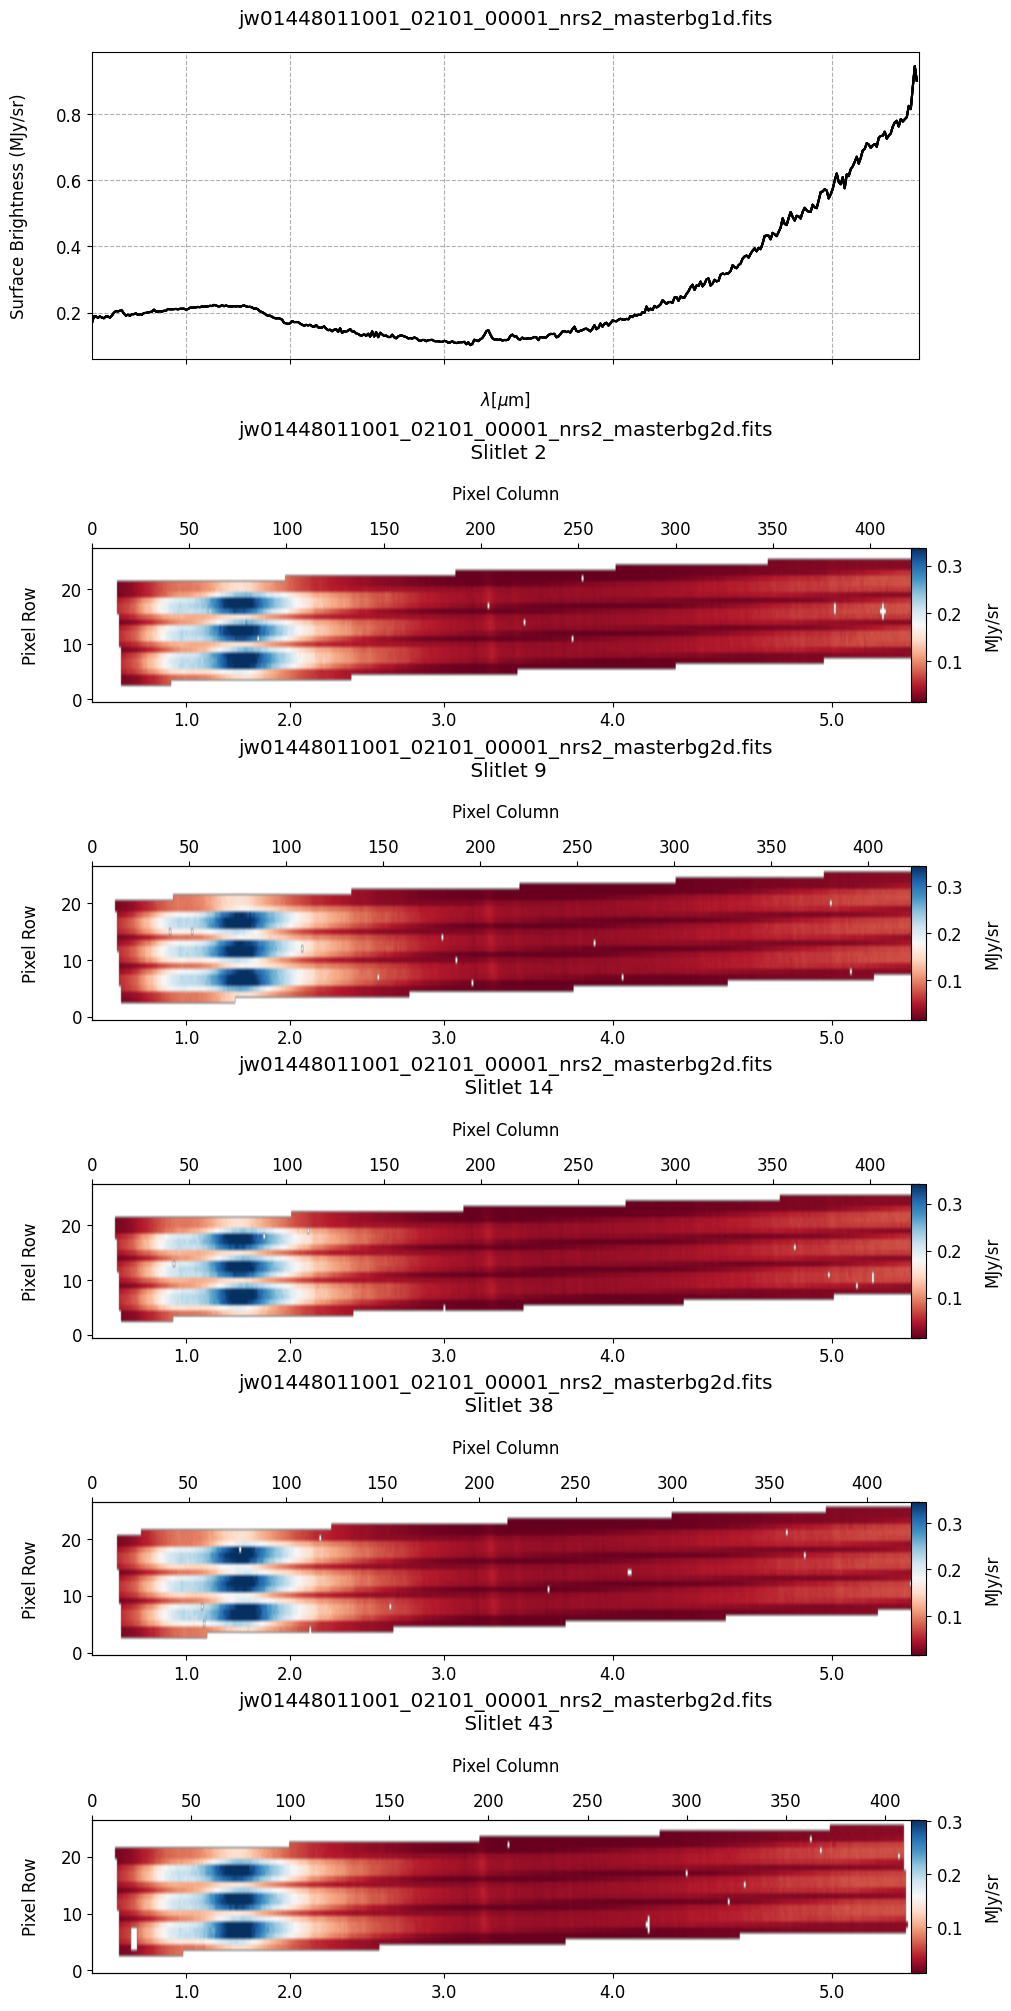

In [118]:
# Plot the 1-D and 2-D master background spectra.
mb_2d = sorted(glob.glob(output_dir_masterbkg+'*_masterbg2d.fits'))
mb_1d = sorted(glob.glob(output_dir_masterbkg+'*_masterbg1d.fits'))

plot_spectra(mb_2d, mb_1d, slit_names=demo_background_slits, hist=False,
             scale=1, cmap='RdBu', figsize=(10, 20), MB=True)

Slit 2: Y-START = 7.0 ; Y-STOP = 12.0
Slit 9: Y-START = 7.0 ; Y-STOP = 12.0
Slit 14: Y-START = 7.0 ; Y-STOP = 12.0
Slit 38: Y-START = 7.0 ; Y-STOP = 12.0
Slit 43: Y-START = 7.0 ; Y-STOP = 12.0


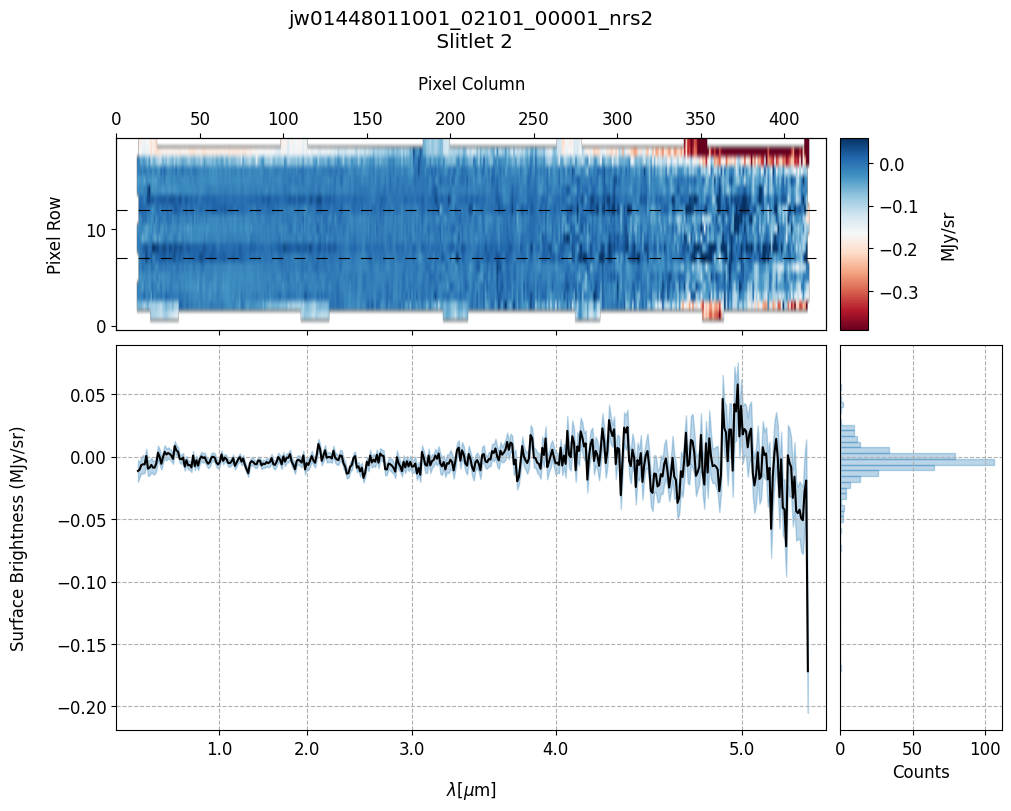

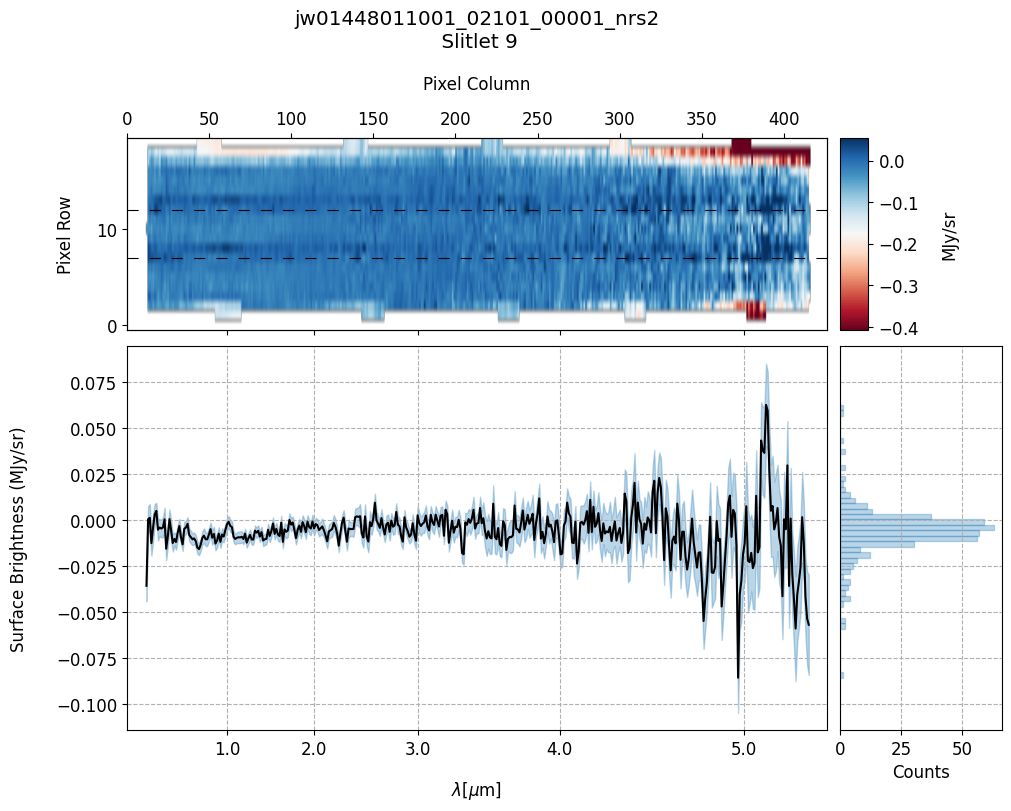

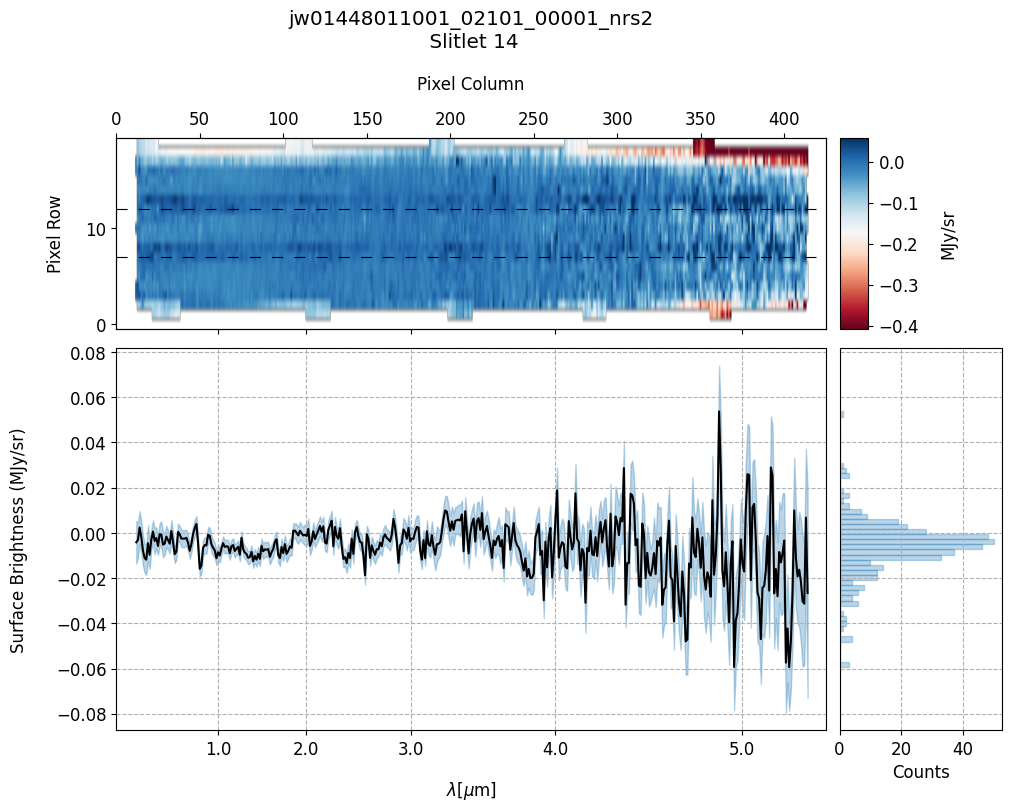

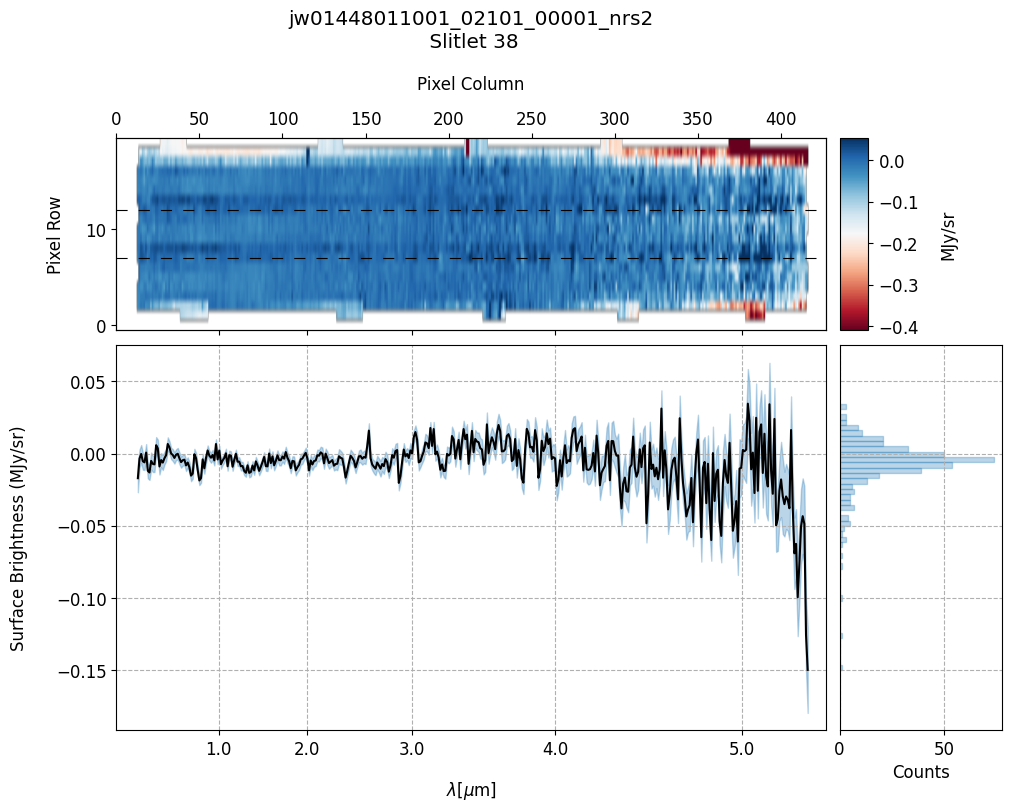

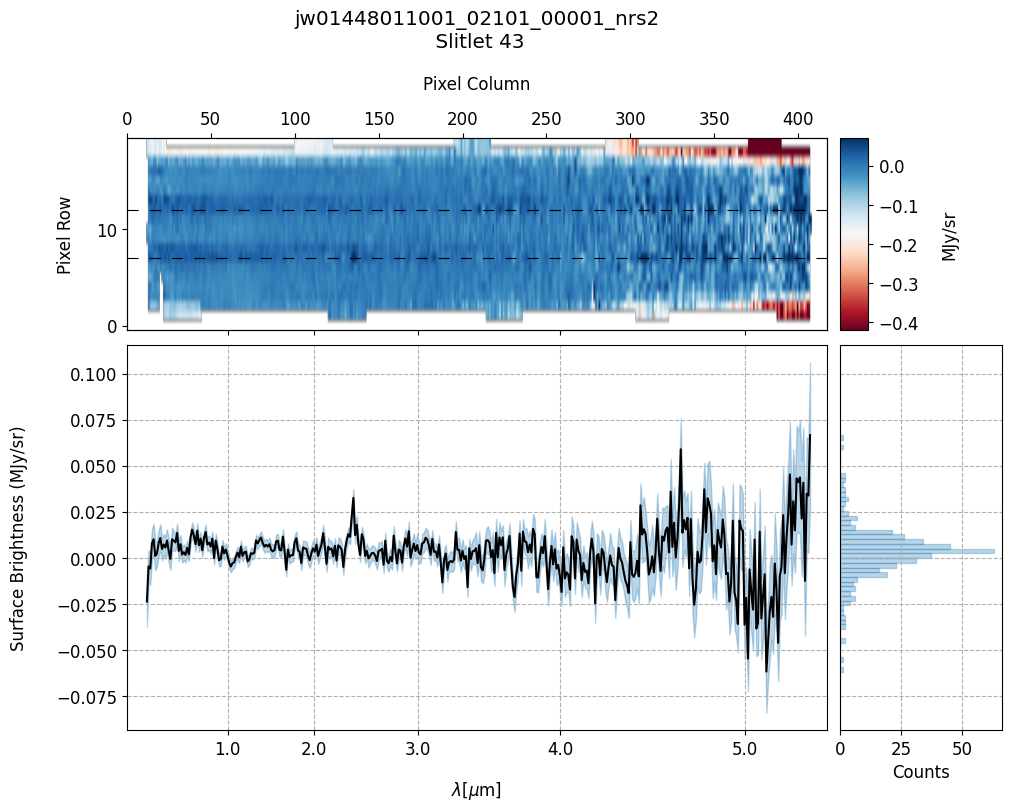

In [59]:
# Plot the master background subtracted spectra.
s2d_mb_files = sorted(glob.glob(output_dir_masterbkg+'*_s2d.fits'))
x1d_mb_files = sorted(glob.glob(output_dir_masterbkg+'*_x1d.fits'))

plot_spectra(s2d_mb_files, x1d_mb_files, slit_names=demo_background_slits,
             scale=1, cmap='RdBu', figsize=(10, 8), hist=True, bins=50,
             fill_nan=False, ycolor='black', ecolor='tab:blue', plot_errors=True)

In [114]:
fits.open(s2d_mb_files[0]).info()

Filename: ./masterbkg_subtraction_MOS_demo/nirspec_product_files_masterbkg_manual/jw01448011001_02101_00001_nrs2_s2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     276   ()      
  1  SCI           1 ImageHDU       101   (425, 20)   float32   
  2  ERR           1 ImageHDU        10   (425, 20)   float32   
  3  WAVELENGTH    1 ImageHDU         9   (425, 20)   float32   
  4  WHT           1 ImageHDU         9   (425, 20)   float32   
  5  CON           1 ImageHDU        10   (425, 20, 1)   int32   
  6  VAR_POISSON    1 ImageHDU         9   (425, 20)   float32   
  7  VAR_RNOISE    1 ImageHDU         9   (425, 20)   float32   
  8  VAR_FLAT      1 ImageHDU         9   (425, 20)   float32   
  9  SCI           2 ImageHDU        75   (426, 20)   float32   
 10  ERR           2 ImageHDU        10   (426, 20)   float32   
 11  WAVELENGTH    2 ImageHDU         9   (426, 20)   float32   
 12  WHT           2 ImageHDU         9   (426, 

<div class="alert alert-block alert-info">


<b>Notes:</b> 
* The 2-D master background spectra are not resampled.
  
* In this demonstration, we are subtracting a master background from the background sources themselves. Consequently, we observe a distribution of values around zero in the final master background-subtracted spectra.

* Note the presence of positive spikes in both the 1D and 2D master background spectra, as well as negative spikes in the background-subtracted spectra, resulting from unflagged hot pixels that were not handled before doing master background subtraction.
</div> 


---

### 7.1 Identify Unmasked Hot/Bad Pixels <a id='hotbadpx'></a>

The following section demonstrates one method for identifying unmasked hot/bad pixels and modifying their corresponding DQ flag to "DO_NOT_USE" using the imported `manually_define_dq_flags` function.

This function works best with the Python package Plotly for interactive plotting. Installation instructions for Plotly are [here](https://github.com/plotly/plotly.py). Plotly generates an interactive plot that allows users to easily hover over hot/bad pixels and obtain their location information (x,y). If Plotly is not installed, a static plot will be returned.

By providing a list of coordinates and setting the parameter `update_dq` to True, the `manually_define_dq_flags` function will modify the DQ flags in the countrate file (*_rate.fits*) for those pixels to "DO_NOT_USE". This flag ensures that identified hot/bad pixels are excluded when extracting 1-D spectra. To confirm the successful implementation of the modifications, rerun *`calwebb_spec2`* in [Section 7](#masterbkg) and utilize the `plot_spectra` function to visualize the resulting spectra.

DQ extension modified successfully.


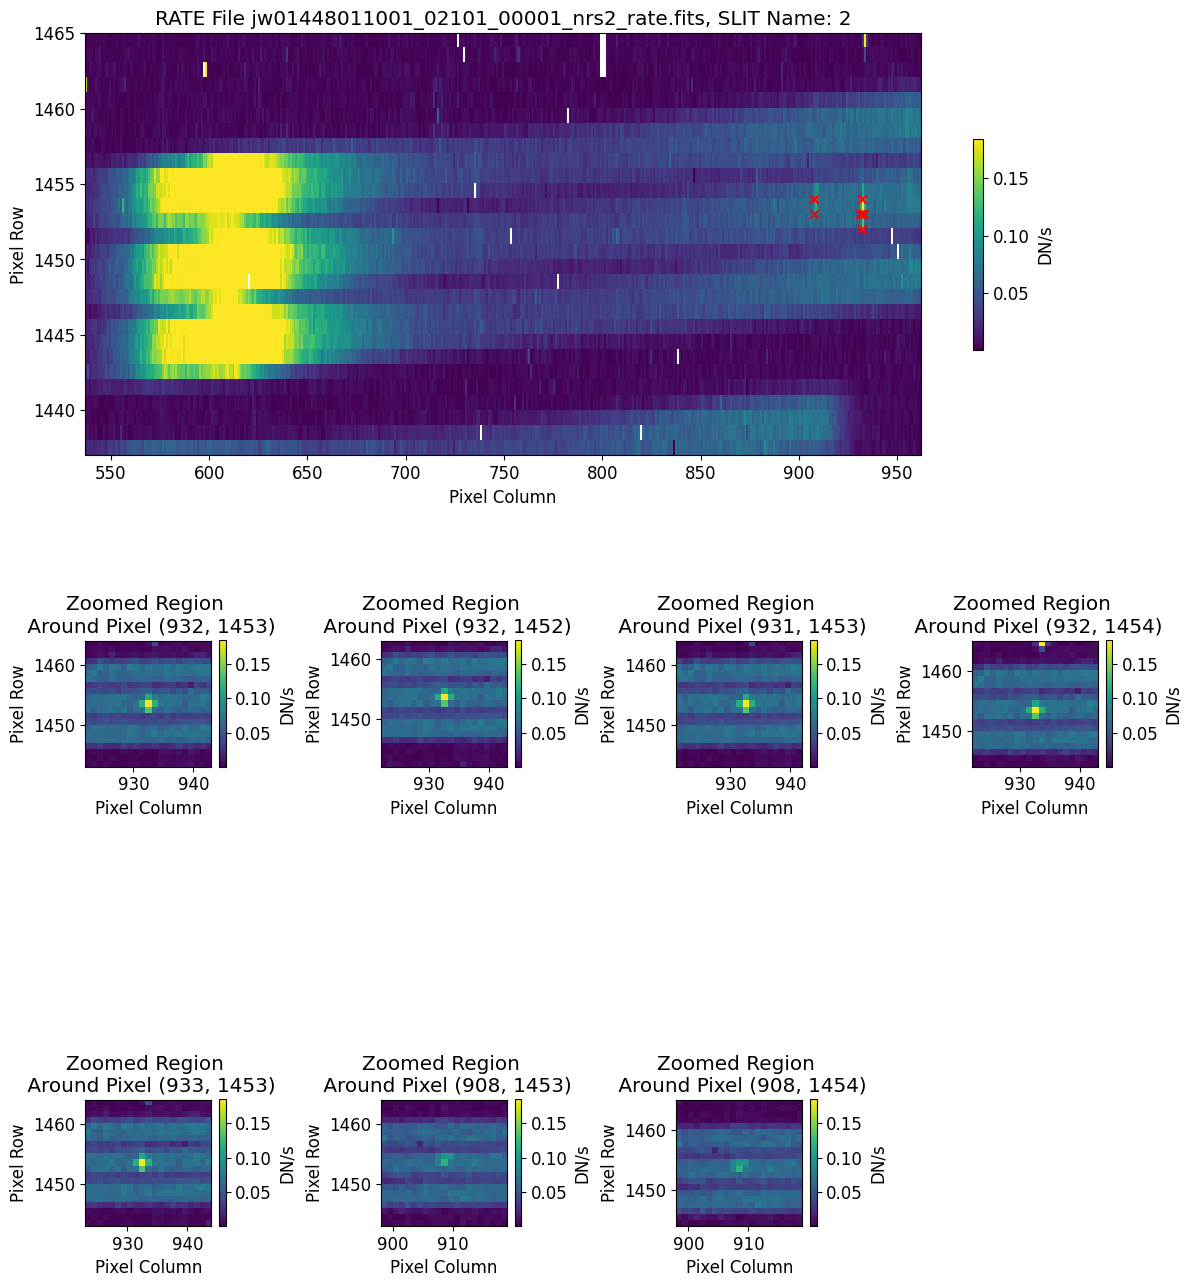

DQ extension modified successfully.


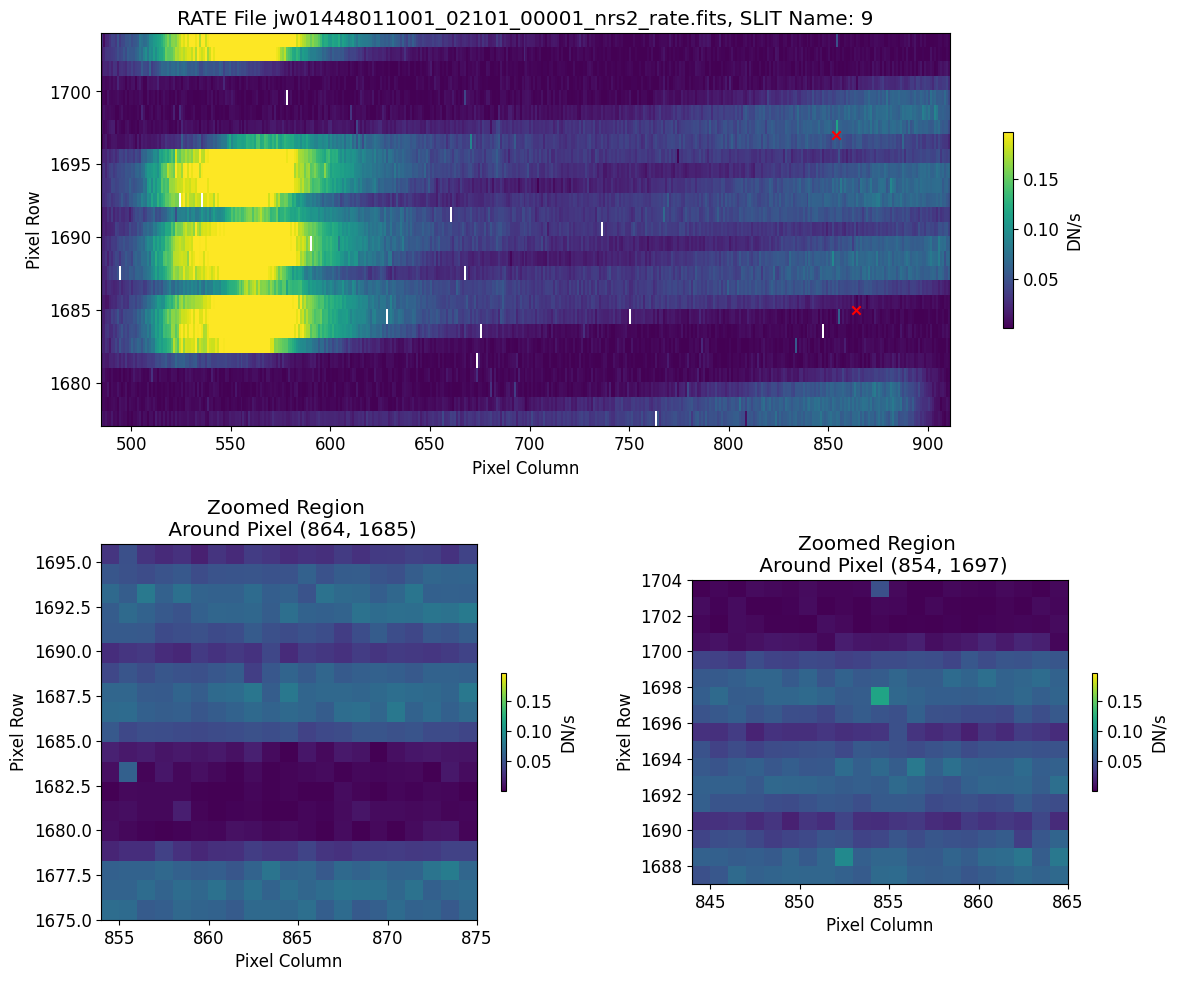

DQ extension modified successfully.


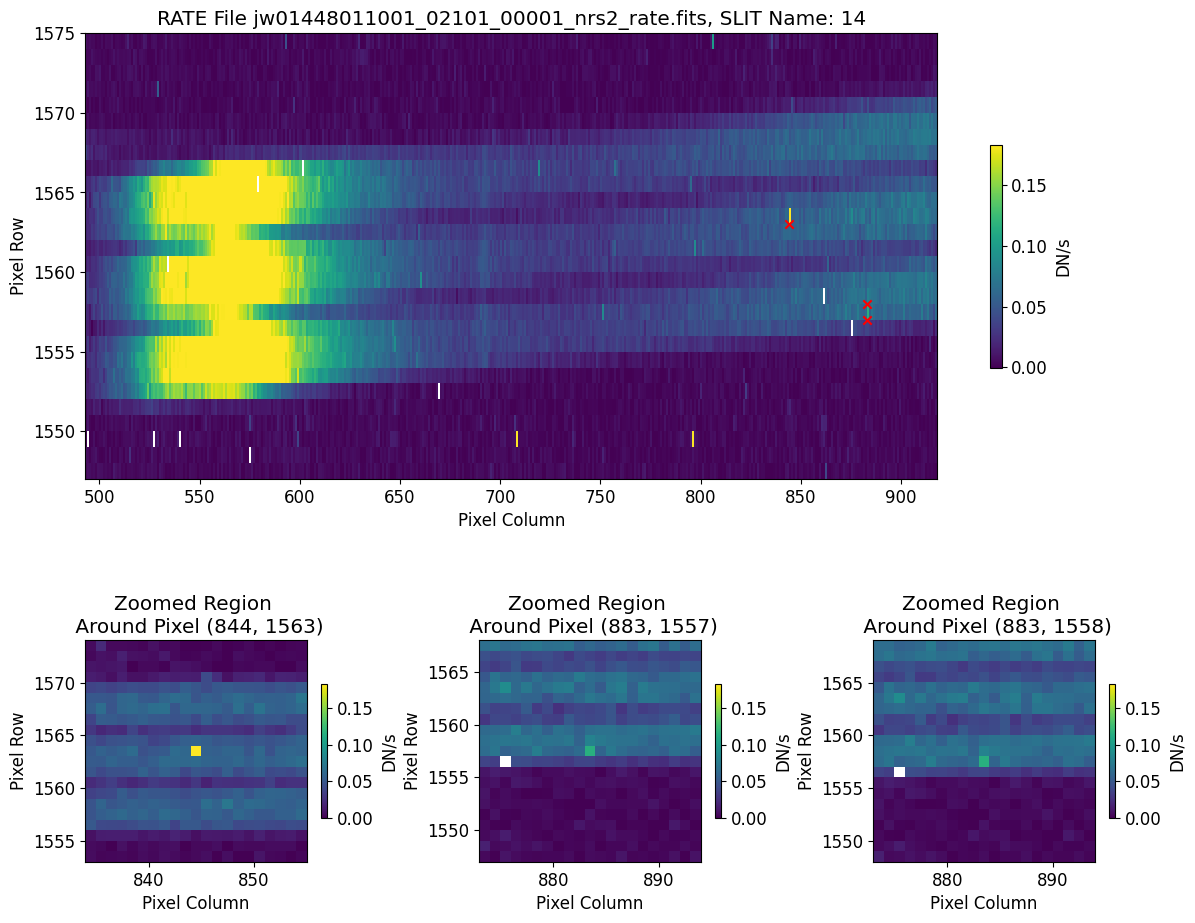

DQ extension modified successfully.


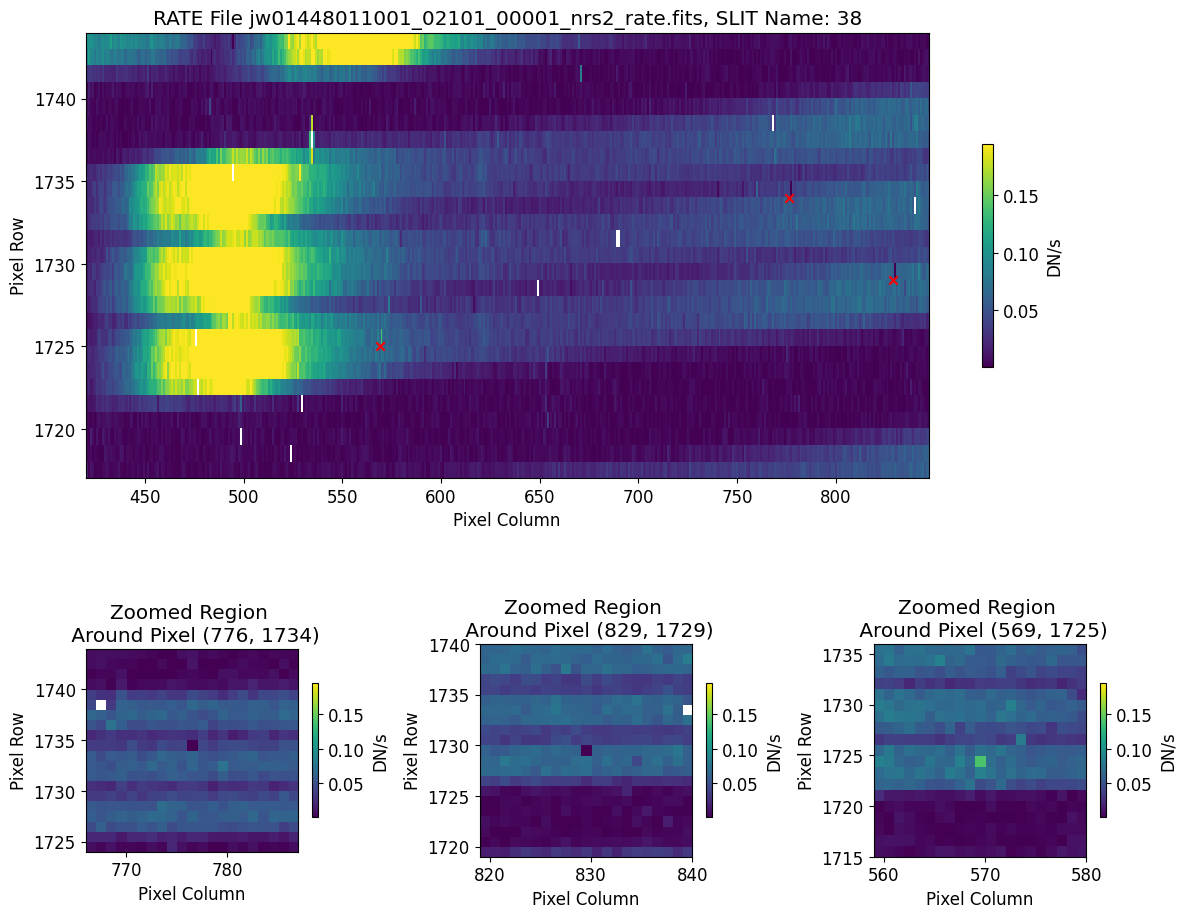

DQ extension modified successfully.


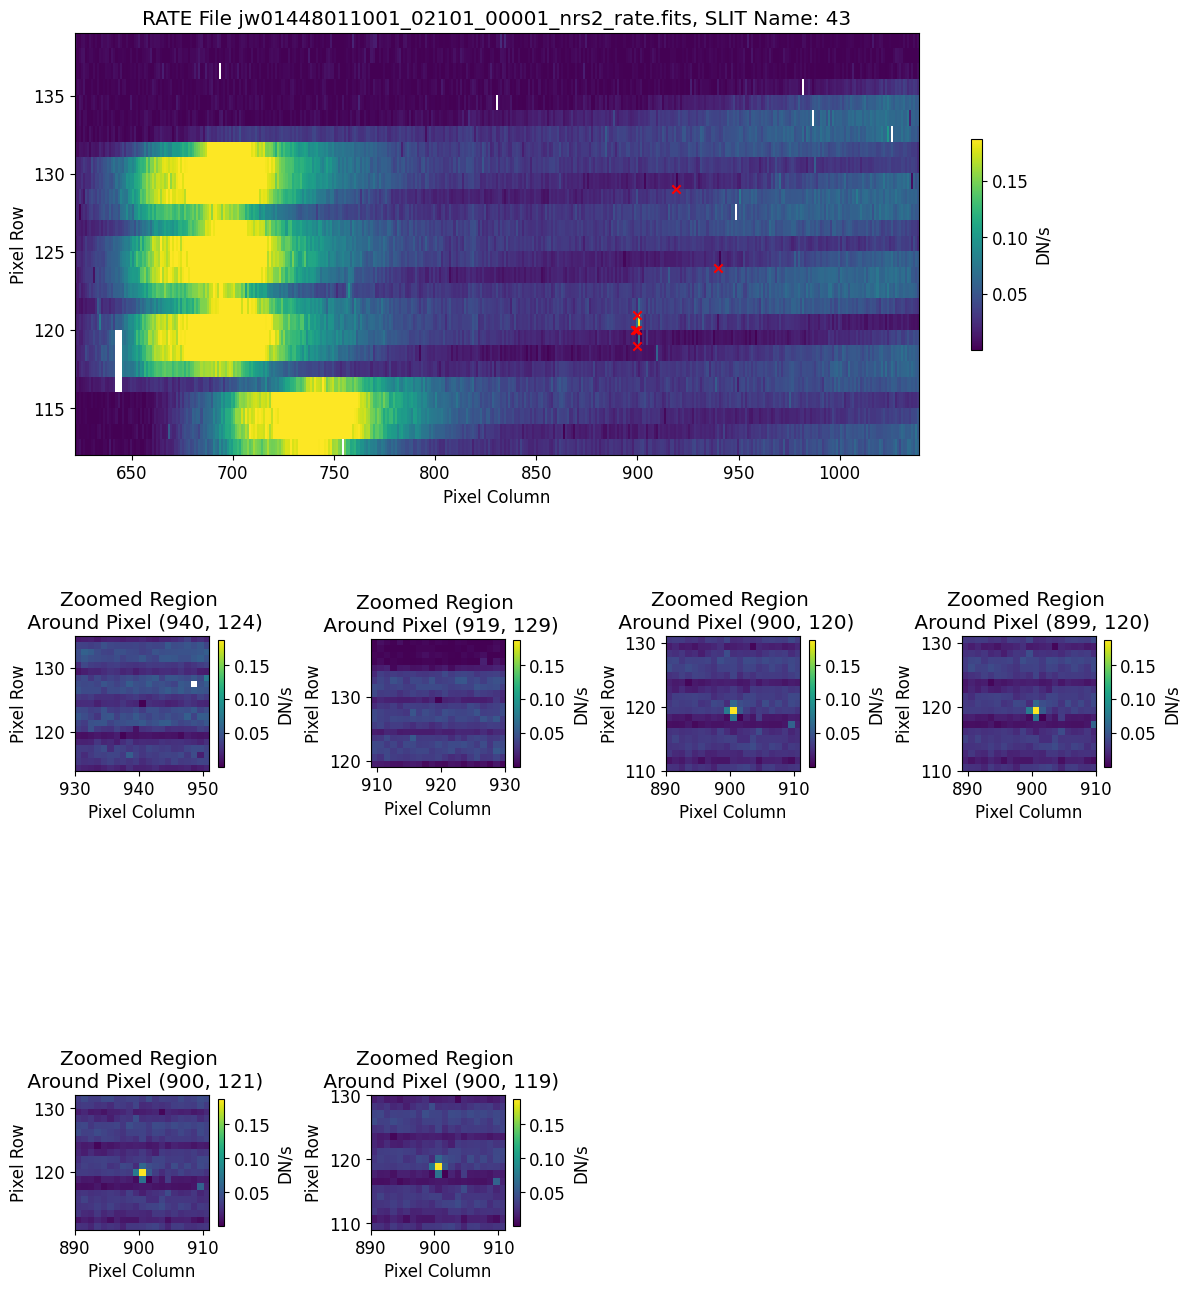

In [60]:
# Identify the hot/bad pixels and update the DQ flags for each vetted background.
rate_file_path = mast_products_dir+'jw01448011001_02101_00001_nrs2_rate.fits'
cal_file_path = output_dir_NObkg+'jw01448011001_02101_00001_nrs2_cal.fits'

update_dq = True

manually_define_dq_flags(rate_file_path, cal_file_path, "2", scale=5,
                         outlier_coords=[(932, 1453), (932, 1452),
                                         (931, 1453), (932, 1454),
                                         (933, 1453), (908, 1453),
                                         (908, 1454)], update_dq=update_dq)

manually_define_dq_flags(rate_file_path, cal_file_path, "9", scale=5,
                         outlier_coords=[(864, 1685), (854, 1697)],
                         update_dq=update_dq)

manually_define_dq_flags(rate_file_path, cal_file_path, "14", scale=5,
                         outlier_coords=[(844, 1563), (883, 1557),
                                         (883, 1558)], update_dq=update_dq)

manually_define_dq_flags(rate_file_path, cal_file_path, "38", scale=5,
                         outlier_coords=[(776, 1734), (829, 1729),
                                         (569, 1725)], update_dq=update_dq)

manually_define_dq_flags(rate_file_path, cal_file_path, "43", scale=5,
                         outlier_coords=[(940, 124), (919, 129),
                                         (900, 120), (899, 120),
                                         (900, 121), (900, 119)],
                         update_dq=update_dq)

<div class="alert alert-block alert-info">

<b>Note:</b> If you prefer to proceed with a 1D master background generated by the pipeline before Build 11.2, rerun the *`calwebb_spec2`* pipeline after manually updating the DQ flags of hot/bad pixels in the cell above. Alternatively, in the next section, we will provide the 1D master background to the pipeline and manage outlier hot/bad pixels by computing a sigma-clipped mean background.
</div> 

---

## 8. Master Background Subtraction: User Supplied Master Background Spectrum <a id='manual'></a>

In [61]:
# Output directories for the user supplied master background.
output_dir_masterbkg_manual = output_dir+'nirspec_product_files_masterbkg_manual/'
if not os.path.exists(output_dir_masterbkg_manual):
    os.makedirs(output_dir_masterbkg_manual)

---

### 8.1 Re-extraction of 1-D Backgrounds Using Modified EXTRACT1D Reference File <a id='extraction'></a>

Re-extract the vetted background slitlets (without applying background subtraction) using non-default EXTRACT1D reference file.

We utilize a modified EXTRACT1D reference file that extracts background from each of the shutters in the 3-shutter slitlets. The default behavior of the pipeline for extended sources is to only extract a 6-pixel wide extraction region centered in the 2-D space of the slit.

In addition to modifying these parameters, we calculate a sigma-clipped mean background instead of computing a weighted average of the background inputs to create the 1-D master background spectrum. This sigma-clipped mean background is then supplied to *`MasterBackgroundMosStep`* in  *`calwebb_spec2`*. The user-supplied 1-D master background spectrum must adhere to the same format as an *_x1d.fits* file. Ensure that the `SURF_BRIGHT` and `WAVELENGTH` columns in the *_x1d.fits* are populated.

In [62]:
# Find and Modify the EXTRACT1D reference file.

refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_extract1d_0009.json'])
extract1d_reffile = refs['jwst_nirspec_extract1d_0009.json']

with open(extract1d_reffile) as f_obj:
    e1dref = json.load(f_obj)
for params in e1dref['apertures']:
    if (params['id'] == 'ANY'):
        params['src_coeff'] = [[2.5], [17.5]]
new_extract1d_ref = output_dir+'jwst_nirspec_extract1d_modified_manual.json'
newfile_ref = open(new_extract1d_ref, 'w')
json.dump(e1dref, newfile_ref)
newfile_ref.close()

In [63]:
# Extract the 1D Spectra from the resampled spectra (_s2d.fits).
if runflag:

    s2d_nobkg_files = sorted(glob.glob(output_dir_NObkg+'*s2d.fits'))

    for s2d_file in s2d_nobkg_files:

        #extract1d_step = Extract1dStep()
        #extract1d_step.save_results = True
        #extract1d_step.output_dir = os.path.abspath(os.path.dirname(s2d_file))
        #extract1d_step.suffix = 'mod_x1d'
        #extract1d_step.use_source_posn = False
        #extract1d_step.output_use_model = True # For file naming
        #extract1d_step.override_extract1d = new_extract1d_ref

        x1d_result = Extract1dStep.call(s2d_file, save_results=True, output_dir=os.path.abspath(os.path.dirname(s2d_file)),
                                        suffix='mod_x1d', use_source_posn=False, output_use_model=True,
                                        override_extract1d=new_extract1d_ref)

/Users/kglidic/Documents/pipeline/jdat_notebooks/notebooks/NIRSpec/mos_master_background/master_background_plot_tools.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metadata_tables[hdu_name] = table_data.to_pandas().applymap(lambda x: x.decode() if isinstance(x, bytes) else x)


Mean COV: 0.026624964302884652
Uncertainty of the Mean COV: 0.0007197178486900077
Master Background FITS file saved to ./user_supplied_mb.fits


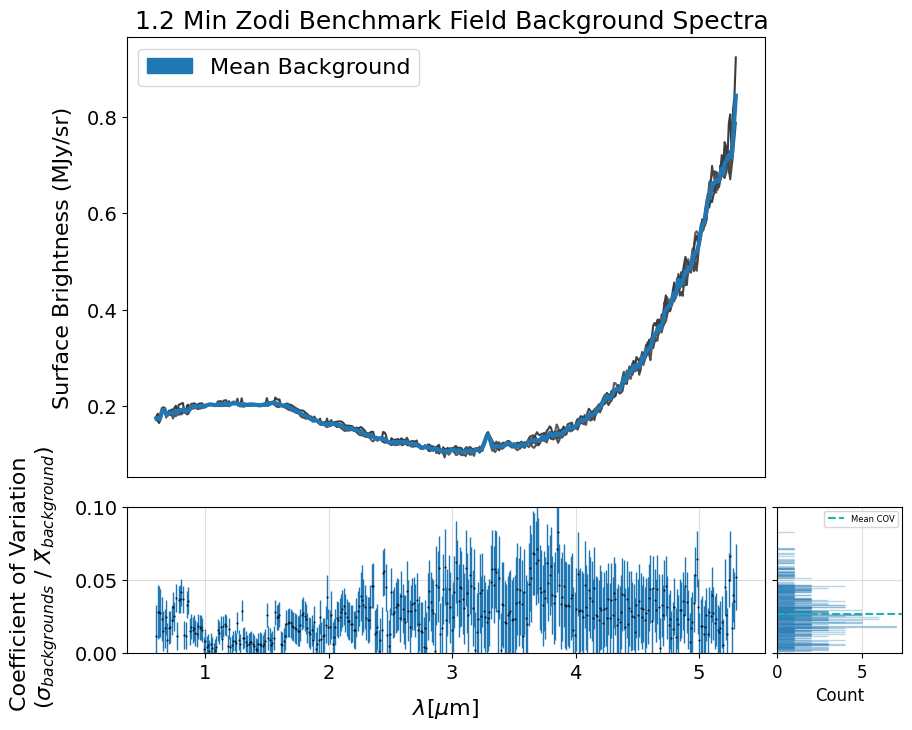

In [64]:
x1d_files_mod = sorted(glob.glob(output_dir_NObkg+'*mod_x1d.fits'))

# Original MSA metadata file path.
metafile_og = mast_products_dir + 'jw01448011001_01_msa.fits'

mb_file, good_bkg_slits = mean_background_variations(x1d_files_mod, metafile_og,
                                                     bin_wavelengths=False,
                                                     vetted_backgrounds=demo_background_slits,
                                                     mad_threshold=5, sigma=2.2,
                                                     mean_color='tab:blue',
                                                     y_lim=None, save_mb=True)

---

Provide the pipeline with the user-supplied 1-D master background spectrum. 

In [65]:
# Stage 2 Processing -- Master Background Subtraction Applied.
# User-supplied master background specrum.

if runflag:

    # Process each rate file seperately.
    for rate_file in sorted(glob.glob(mast_products_dir+'*rate.fits')):
        # Update the msa metadata file for master background subtraction
        print("Changing MSAMETFL Keyword for {}".format(os.path.basename(rate_file)))
        with fits.open(rate_file, 'update') as ratefile_hdu:
            ratefile_hdu[0].header['MSAMETFL'] = os.path.basename(metafile_mb)
        ratefile_hdu.close()

        print("Applying Stage 2 Calibrations & Corrections to: " +
              os.path.basename(rate_file))

        # Adjust `slit_y_low`/`slit_y_high` as needed to center slitlet in 2-D cutout.
        spec2_params = {'assign_wcs': {'slit_y_low': -0.55, 'slit_y_high': 0.35},
                        # Save generated master background.
                        'master_background_mos': {'skip': False,
                                                  # Provide user-supplied master background.
                                                  'user_background': mb_file,
                                                  'save_background': True,
                                                  'steps': {'barshadow': {
                                                      'override_barshadow': barshadow_reffile}
                                                  }},
                        'bkg_subtract': {'skip': True}, # Skip pixel-to-pixel.

                        # Fill non-science pixels with NaNs in the final
                        # background-subtracted resampled spectra (not 0's)
                        # so they don't get included in Extract1D step.
                        # Use resample weight type ivm as it lets through less outliers.
                        'resample_spec': {'fillval': 'nan', 'weight_type': 'ivm'},
                        # Override for newer barshadow correction reference file.
                        'barshadow': {'override_barshadow': barshadow_reffile}}

        Spec2Pipeline.call(rate_file, save_results=True,
                           output_dir=output_dir_masterbkg_manual, steps=spec2_params)

Changing MSAMETFL Keyword for jw01448011001_02101_00001_nrs2_rate.fits
Applying Stage 2 Calibrations & Corrections to: jw01448011001_02101_00001_nrs2_rate.fits


In [80]:
from jwst import datamodels
datamodels.open(mb_2d[0]).search("flat")




root (AsdfObject)
├─cal_logs (dict)
│ └─flat_field (list): []
├─meta (dict)
│ ├─cal_step (dict)
│ │ └─flat_field (str): COMPLETE
│ └─ref_file (dict)
│   ├─dflat (dict): {'name': 'crds://jwst_nirspec_dflat_0002.fits'}
│   ├─fflat (dict): {'name': 'crds://jwst_nirspec_fflat_0163.fits'}
│   ├─flat (dict): {'name': 'jw01448011001_02101_00001_nrs2_rate.fits'}
│   └─sflat (dict): {'name': 'crds://jwst_nirspec_sflat_0233.fits'}
└─slits (list)
  ├─[0] (AsdfObject)
  │ ├─meta (dict) ...
  │ └─var_flat (ndarray)
  ├─[1] (AsdfObject)
  │ ├─meta (dict) ...
  │ └─var_flat (ndarray)
  ├─[2] (AsdfObject)
  │ ├─meta (dict) ...
  │ └─var_flat (ndarray)
  ├─[3] (AsdfObject) ...
  └─[4] (AsdfObject) ...
Some nodes not shown.

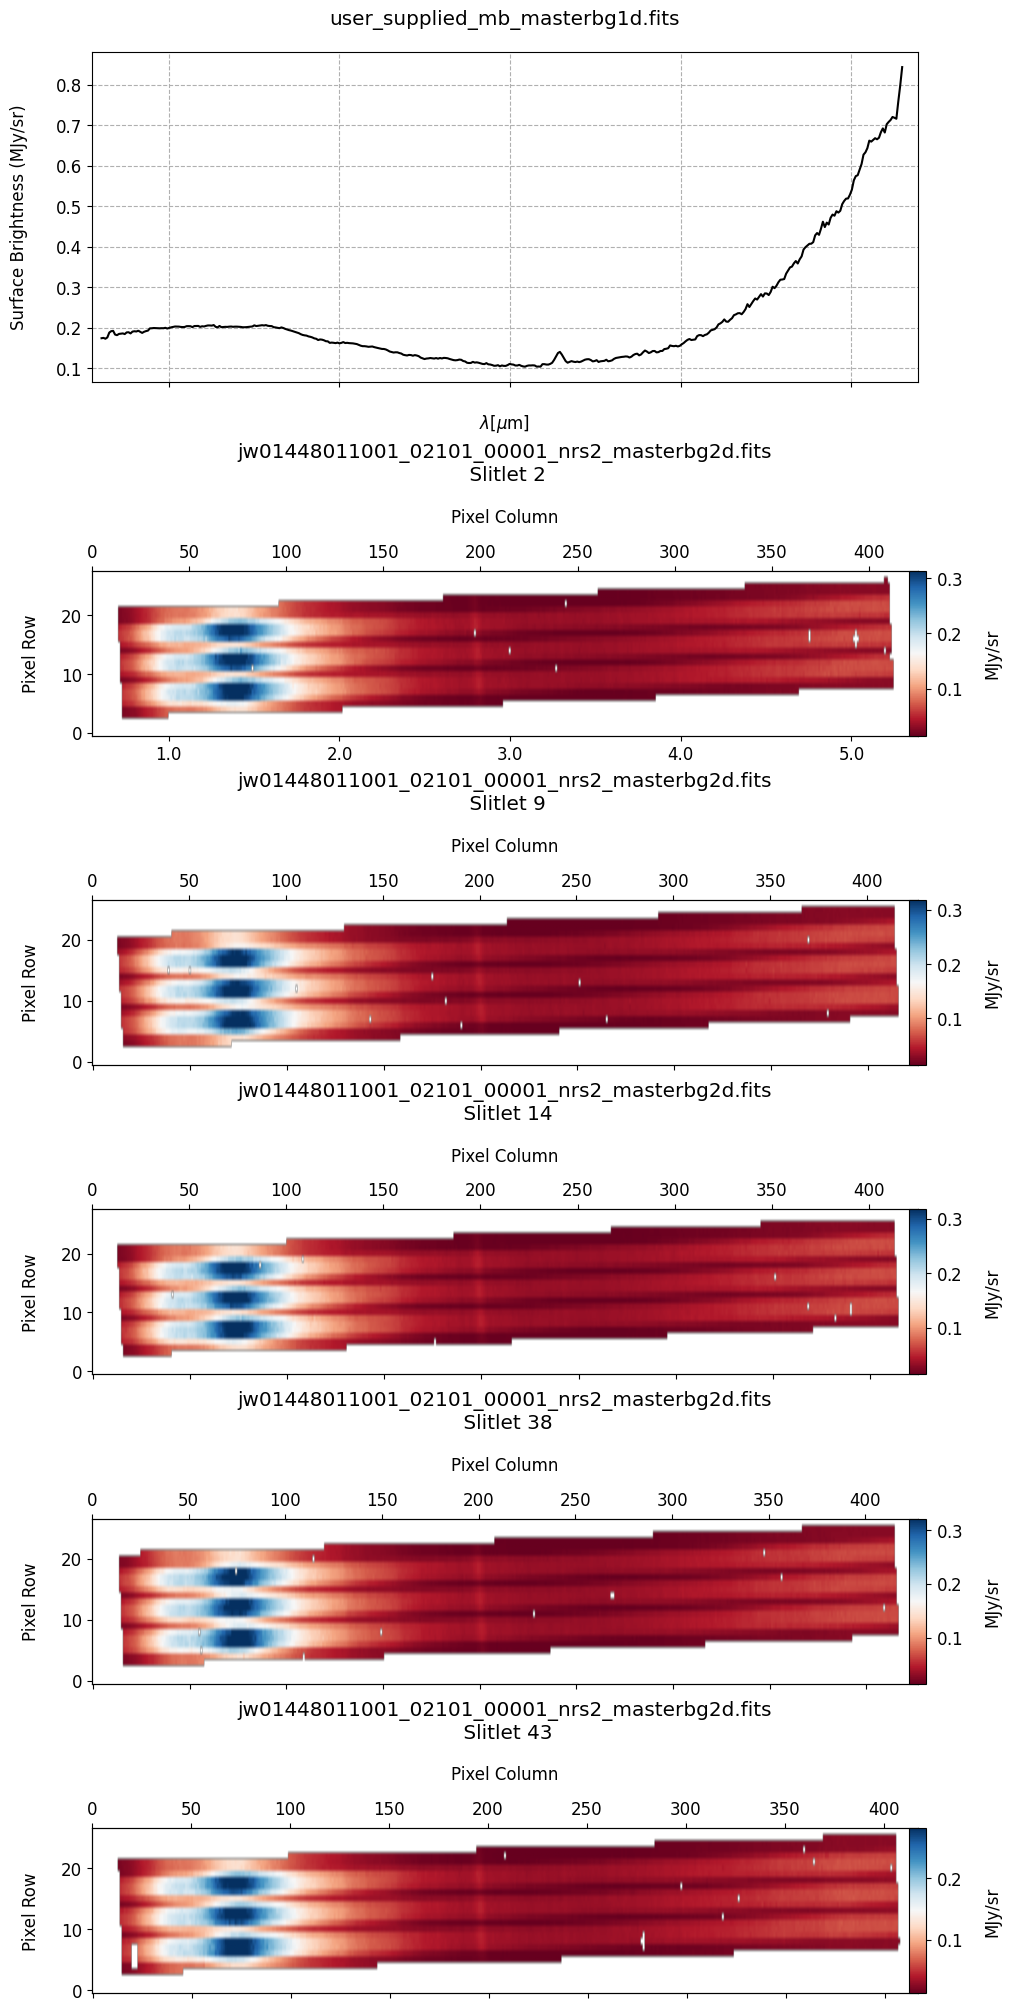

In [66]:
# Plot the master background spectra.
mb_2d_user = sorted(glob.glob(output_dir_masterbkg_manual+'*_masterbg2d.fits'))
mb_1d_user = sorted(glob.glob(output_dir_masterbkg_manual+'*_masterbg1d.fits'))

plot_spectra(mb_2d_user, mb_1d_user, slit_names=demo_background_slits,
             scale=1, cmap='RdBu', figsize=(10, 20), hist=False,
             fill_nan=False, MB=True, plot_errors=False)

Slit 2: Y-START = 7.0 ; Y-STOP = 12.0
Slit 9: Y-START = 7.0 ; Y-STOP = 12.0
Slit 14: Y-START = 7.0 ; Y-STOP = 12.0
Slit 38: Y-START = 7.0 ; Y-STOP = 12.0
Slit 43: Y-START = 7.0 ; Y-STOP = 12.0


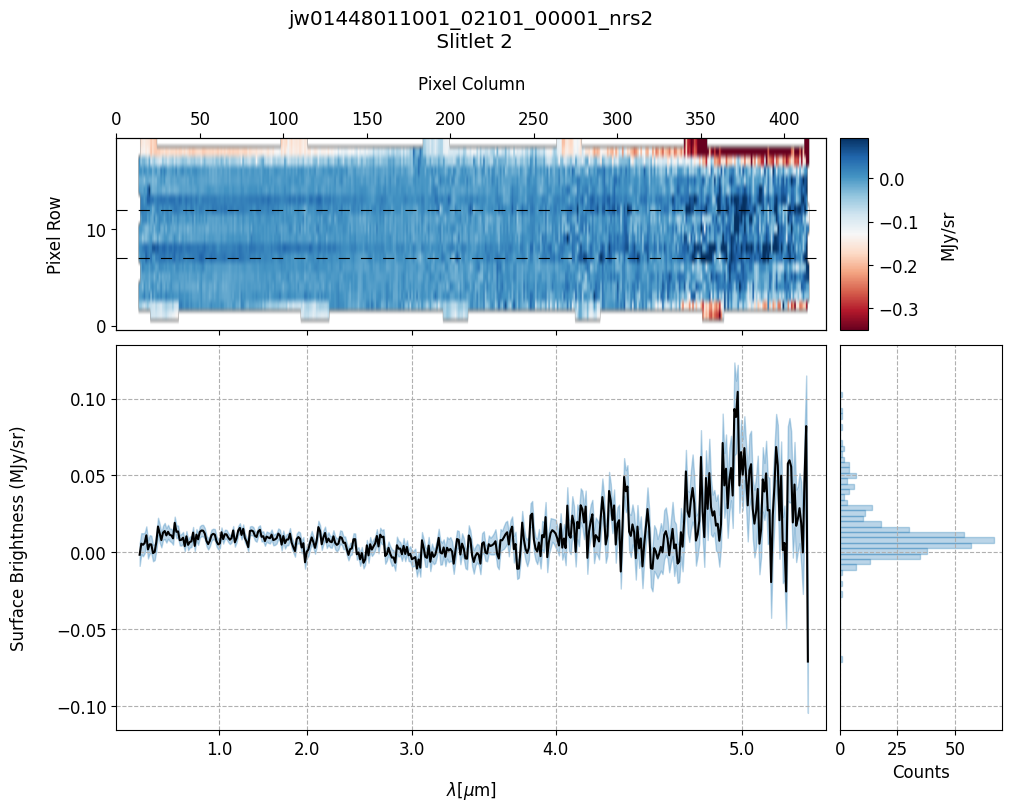

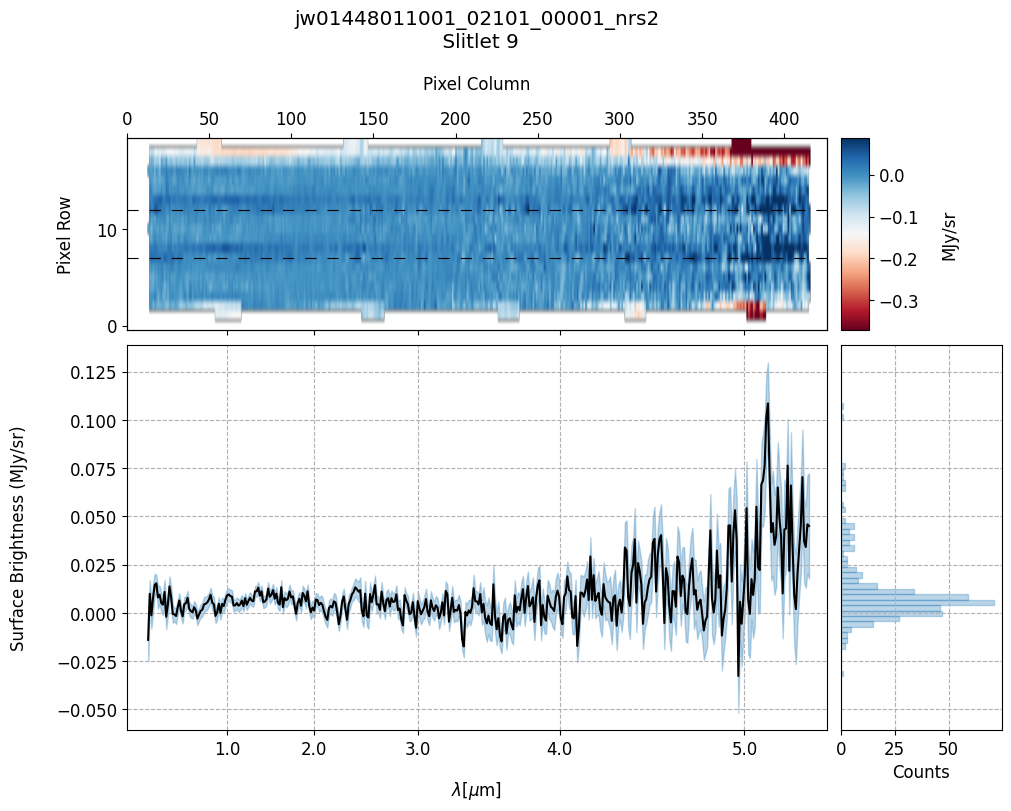

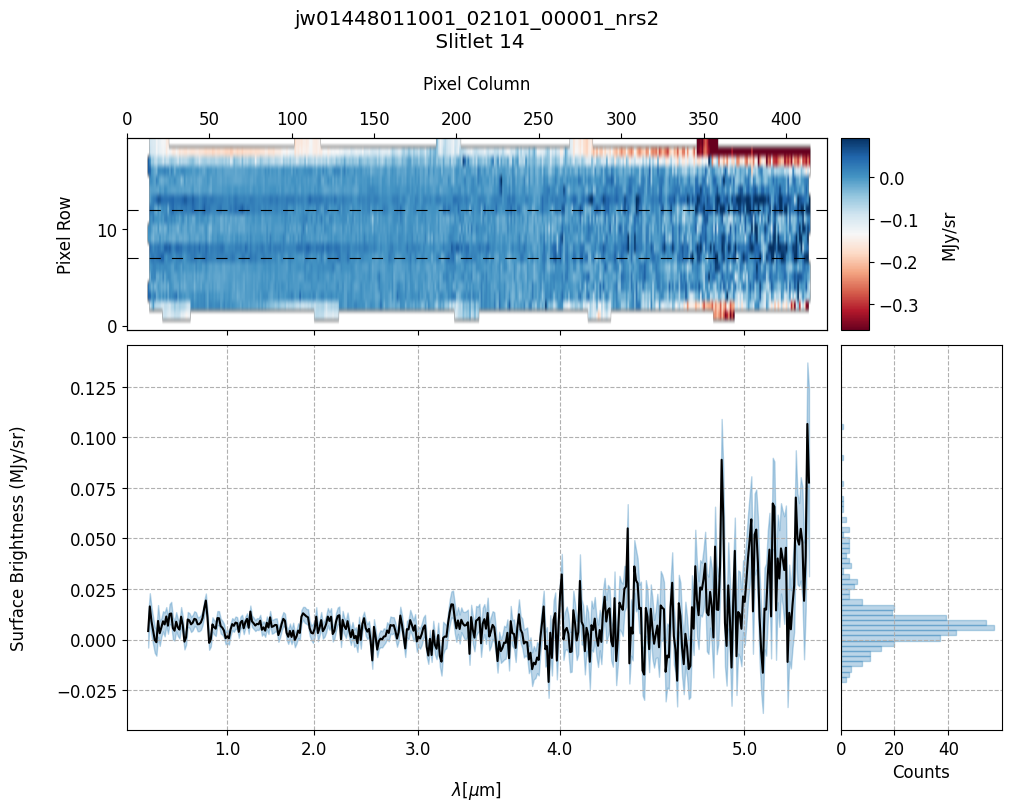

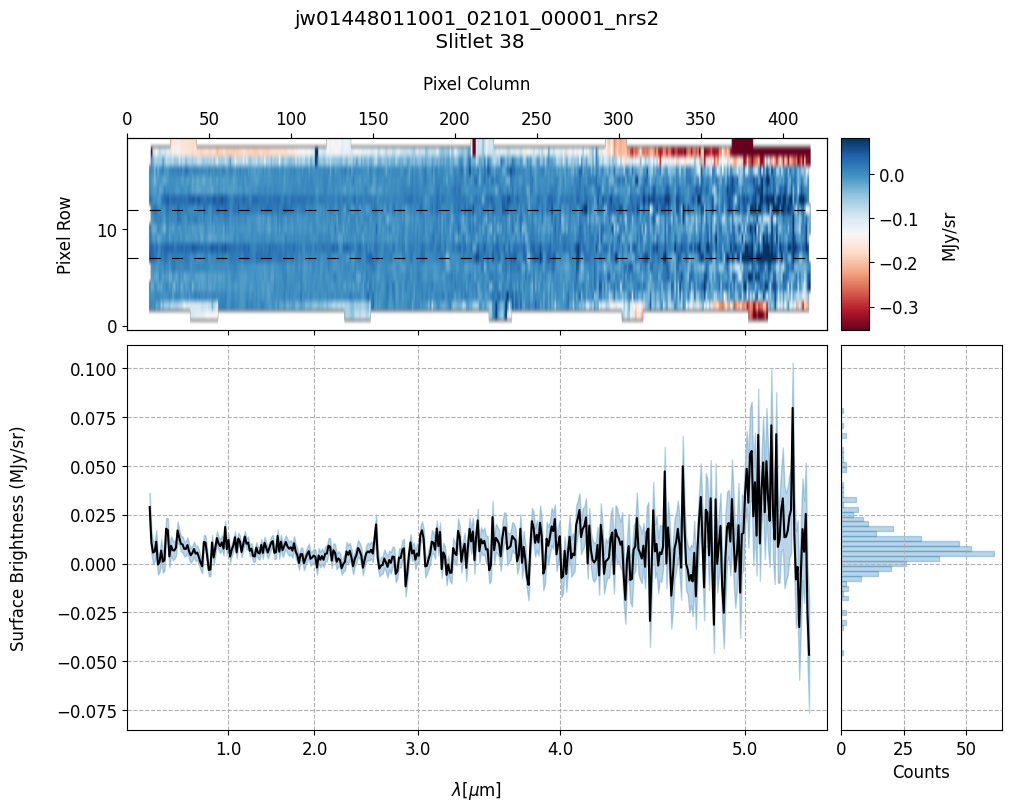

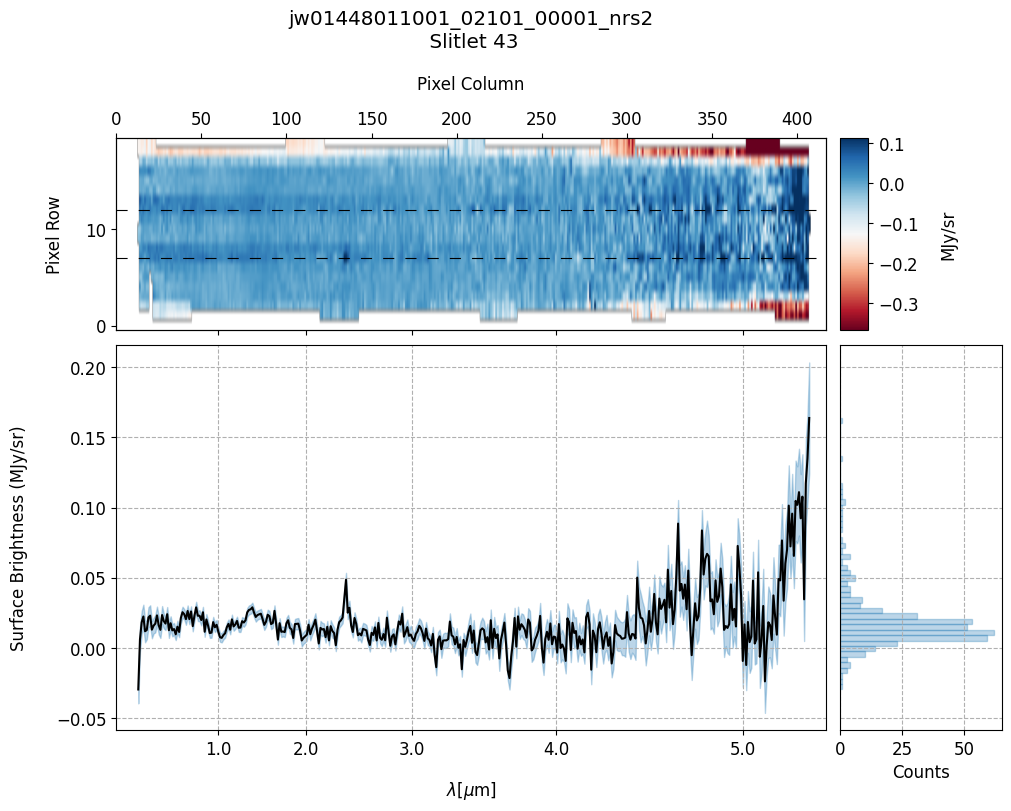

In [67]:
# Plot the master background-subtracted spectra.
s2d_mb_files = sorted(glob.glob(output_dir_masterbkg_manual+'*_s2d.fits'))
x1d_mb_files = sorted(glob.glob(output_dir_masterbkg_manual+'*_x1d.fits'))

plot_spectra(s2d_mb_files, x1d_mb_files, slit_names=demo_background_slits,
             scale=1, cmap='RdBu', figsize=(10, 8), hist=True, bins=50,
             fill_nan=False, ycolor='black', ecolor='tab:blue', plot_errors=True)

---
## 9. Conclusion <a name="conclusion"></a>

The calibrated background-subtracted products (*_cal.fits*) resulting from the above `Spec2Pipeline` run are now ready for further processing. These files can serve as input for the `Spec3Pipeline` to generate final combined spectra.



[Top of Page](#top)